<a href="https://colab.research.google.com/github/Pevernow/noise_step/blob/master/noise_step_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA available. Using GPU: Tesla T4


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.81MB/s]


Batch loaded successfully to device.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Samples per step (JVP batch): 128
Initial noise density: 2.389e-05
Adaptive Noise Params: window=30, stable_thr=0.005, unstable_thr=0.05
                     : decrease_factor=0.95, increase_factor=1.02
                     : min_density=1.49e-06, max_density=9.56e-05
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Step [1/2000], Loss: 19.9223, Acc: 9.98%, Align: 0.0040, NoiseDens: 2.39e-05
Step [21/2000], Loss: 5.1141, Acc: 33.75%, Align: 0.0009, NoiseDens: 2.39e-05

Step 30: Align change low (0.0002 < 0.005). Increasing noise density.
    New noise density: 2.44e-05

Step 31: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.49e-05

Step 32: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.54e-05

Step 33: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.59e-05

Step 34: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.64e-05

Step 35: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.69e-05

Step 36: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.74e-05

Step 37: Align change low (0.0001 < 0.005). Increasing noise density.
    New noise density: 2.80e-05

Step 38: Align chang

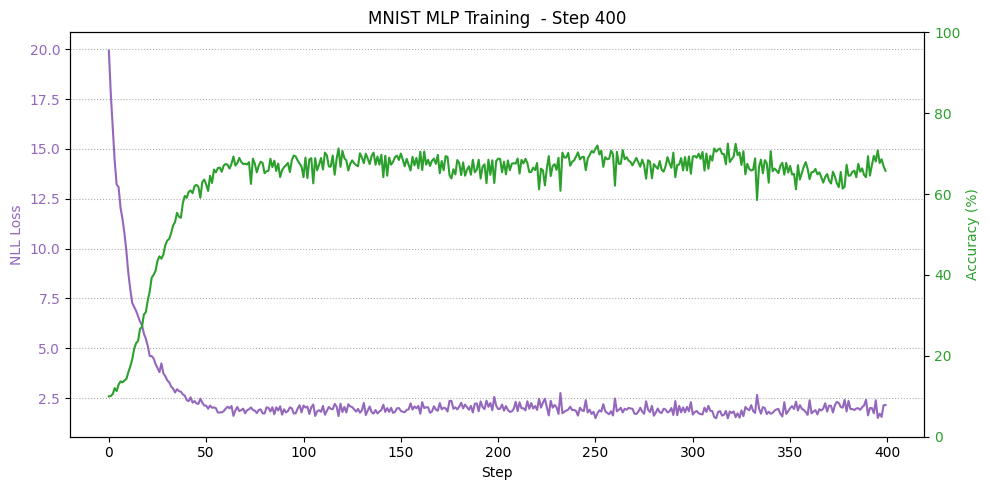

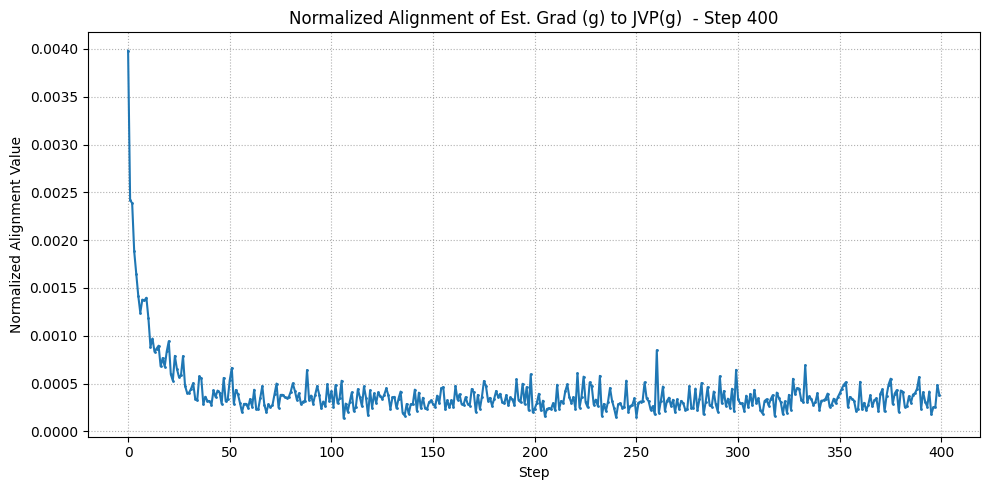


Step 401: Align change low (0.0001 < 0.005). Increasing noise density.
Step [401/2000], Loss: 1.9401, Acc: 67.30%, Align: 0.0003, NoiseDens: 9.56e-05

Step 402: Align change low (0.0001 < 0.005). Increasing noise density.

Step 403: Align change low (0.0001 < 0.005). Increasing noise density.

Step 404: Align change low (0.0001 < 0.005). Increasing noise density.

Step 405: Align change low (0.0001 < 0.005). Increasing noise density.

Step 406: Align change low (0.0001 < 0.005). Increasing noise density.

Step 407: Align change low (0.0001 < 0.005). Increasing noise density.

Step 408: Align change low (0.0001 < 0.005). Increasing noise density.

Step 409: Align change low (0.0001 < 0.005). Increasing noise density.

Step 410: Align change low (0.0001 < 0.005). Increasing noise density.

Step 411: Align change low (0.0001 < 0.005). Increasing noise density.

Step 412: Align change low (0.0001 < 0.005). Increasing noise density.

Step 413: Align change low (0.0001 < 0.005). Increasing 

In [ ]:
# -*- coding: utf-8 -*-
"""
lk99_proof_adaptive_batched.py

Modification of the original lk99_proof code to include:
1. Batched JVP computation using torch.func.vmap for potentially faster gradient estimation.
2. Adaptive noise density adjustment based on the rate of change of alignment.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
from collections import deque # For tracking recent alignments

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Modified Helper Functions for GPU ---

# Note: device argument added to functions creating tensors

def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  # Ensure constants are on the right device or compatible type
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  # Infer device from tensor if not specified
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  # Ensure resulting tensor is on the correct device
  return tch.where(signal < level, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

# balanced ternary noise with symbol distribution w = [ -1 = a, 0 = b, +1 = c ]
def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    # Note: Seeding affects CPU and GPU random number generators differently.
    # For perfect reproducibility across devices, more careful seeding might be needed.
    tch.manual_seed(seed)
    if device == tch.device("cuda"):
        tch.cuda.manual_seed_all(seed) # Seed all GPUs
  # Create random tensor directly on the specified device
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

# binary noise
def rand_mask(shape, p, device=None):
  # Create random tensor directly on the specified device
  random_tensor = tch.rand(shape, device=device)
  # Ensure p is on the same device or is a scalar
  p_tensor = tch.tensor(min(max(p, 0), 1), device=device)
  return lt(random_tensor, p_tensor, device=device)

def randu(): # Usually for single values, CPU is fine, but can specify device if needed
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

# given a mean value, generate random probabilities for symbols [a = -1, b = 0, c = 1]
# warning: the probabilities themselves are random
# generate random probabilities for symbols [a = -1, b = 0, c = 1] such that mean value is found.
def probs(mean, sparsity = None):
  # This function returns Python list of floats, no device needed here
  z_min = max(abs(mean) - 1, 0) # { -1, 0, +1 } -> { 0, 0, 0 }
  z_max = min(1 - abs(mean), 1) # { -1, 0, +1 } -> { 1, 1, 0 }
  p_z = rand_between(z_min, z_max).item() if sparsity == None else min(max(sparsity, z_min), z_max)

  n_min = max(-mean / 2, 0)
  n_max = min(-(mean - 1) / 2, 1)
  # Ensure calculations stay within bounds [0, 1] for probabilities
  p_n_candidate = (1 - p_z - mean) / 2
  p_n = min(max(p_n_candidate, n_min), n_max)
  p_u = 1.0 - p_n - p_z # Calculate p_u based on p_n and p_z summing to 1
  # Due to potential floating point inaccuracies or edge cases, clamp results
  p_n = min(max(p_n, 0.0), 1.0)
  p_z = min(max(p_z, 0.0), 1.0)
  p_u = min(max(p_u, 0.0), 1.0)
  # Re-normalize slightly if needed due to clamping/float issues
  total_p = p_n + p_z + p_u
  if not math.isclose(total_p, 1.0):
      # Avoid division by zero if total_p is somehow 0
      if total_p > 1e-9:
          p_n /= total_p
          p_z /= total_p
          p_u /= total_p
      else: # Handle edge case where all might be clamped to 0
          # Default to uniform if normalization fails badly
          p_n, p_z, p_u = 1/3, 1/3, 1/3


  return [p_n, p_z, p_u]

# Generate sign noise (-1, 1) with a specific mean
def sign_noise(shape, mean = 0.0, device=None):
  # Pass device to rand_tern
  return rand_tern(shape, probs(mean, sparsity=0), device=device)

# --- Modified Data Loading for GPU ---
def get_batch(batch_size, device): # Added device argument
  transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0).float() # Binarize the image to {0, 1}
  ])
  # Consider adding num_workers > 0 and pin_memory=True to DataLoader for faster transfer if GPU is used
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0 # Use workers if using GPU/pin_memory
  mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)

  # Ensure batch_size doesn't exceed dataset size
  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size == 0:
      raise ValueError("Batch size cannot be zero")

  # Use random sampling without replacement for indices
  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)

  # Use num_workers=0 if you encounter issues, especially on Windows or macOS with certain setups
  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except Exception as e:
      print(f"DataLoader error with num_workers={num_workers}, trying num_workers=0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))

  data, target = batch
  # Move data and target tensors to the specified device
  data = data.to(device, non_blocking=pin_memory) # Use non_blocking with pin_memory
  target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test fetching a batch to the selected device
try:
    _ = get_batch(1, device)
    print("Batch loaded successfully to device.")
except Exception as e:
    print(f"Error loading batch: {e}")

# Ensure MNIST data is downloaded if not present
try:
    datasets.MNIST('../data', train=True, download=True)
except Exception as e:
    print(f"Could not download MNIST data: {e}")
    # Consider exiting or using a fallback if data is essential

# --- Network Definition (No GPU-specific changes needed here) ---
# PyTorch layers automatically handle tensors on the correct device

def layer_norm(x, eps=1e-5):
  # Assumes x is already on the correct device
  # Normalize over the feature dimension (last dimension)
  mean = tch.mean(x, dim=-1, keepdim=True)
  var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps) # Use sqrt for std dev

def total_params(input_size, hidden_size, output_size):
  ti = 0
  ti += input_size * hidden_size
  ti += hidden_size
  ti += hidden_size * hidden_size
  ti += hidden_size
  ti += hidden_size * output_size
  ti += output_size
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  # Assumes t_params and x are on the same correct device
  ti = 0

  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size)
  ti += input_size * hidden_size

  b1 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size)
  ti += hidden_size * hidden_size

  b2 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size)
  ti += hidden_size * output_size

  b3 = t_params[ti:ti+output_size].view(output_size)
  ti += output_size

  # Forward pass
  x = x.view(-1, input_size) # Flatten input

  # Layer 1
  x = x @ w1.t() + b1
  x = layer_norm(x) # Apply layer norm
  x = F.relu(x)

  # Layer 2
  x = x @ w2.t() + b2
  x = layer_norm(x) # Apply layer norm
  x = F.relu(x)

  # Output Layer
  x = x @ w3.t() + b3
  output = F.log_softmax(x, dim=1) # Use log_softmax for NLLLoss

  return output

# --- Loss and Accuracy Functions (No GPU-specific changes needed here) ---
# They operate on tensors passed to them, which should already be on the correct device

def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch # data and target are already on the device
  output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  # Ensure target has the correct shape and type (long)
  loss = F.nll_loss(output, target.long()) # NLLLoss expects log-probabilities
  return loss # loss is a scalar tensor on the device

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch # data and target are already on the device
  # Disable gradient calculation for accuracy computation
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item() # .item() moves sum (scalar) to CPU
      total = target.size(0)
  accuracy = 100.0 * correct / total # Ensure float division
  return accuracy # accuracy is a Python float

# --- Plotting Function (No GPU-specific changes needed) ---
# Expects Python lists/numbers (already transferred from GPU if needed)

def plot(loss_record, acc_record, align_record, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 5)) # Wider plot
    title = f"MNIST MLP Training {title_suffix}"
    plt.title(title) # Set combined title

    # Loss Plot
    color = 'tab:purple'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('NLL Loss', color=color)
    ax1.plot(loss_record, color=color, linestyle='-', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y', linestyle=':') # Add light grid for y-axis

    # Accuracy Plot
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(acc_record, color=color, linestyle='-', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100) # Accuracy bounded [0, 100]

    fig.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    # Alignment Plot
    plt.figure(figsize=(10, 5)) # Separate figure, wider
    plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step")
    plt.ylabel("Normalized Alignment Value")
    # Filter NaNs before plotting alignment
    steps_align = [i for i, x in enumerate(align_record) if not np.isnan(x)]
    align_vals = [x for x in align_record if not np.isnan(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2) # Smaller markers
    plt.grid(True, linestyle=':') # Add grid
    plt.tight_layout()
    plt.show()


# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512
output_size = 10
samples = 128 # Number of perturbations per step for gradient estimation
eval_batch_size_factor = 5 # Factor of training batch_size for evaluation
eval_batch_max = 10000 # Max samples for evaluation accuracy

# ternary dimension
dim = total_params(input_size, hidden_size, output_size)

# init: Create theta directly on the target device
theta = rand_tern((dim,), device=device, requires_grad=False) # No grad needed for theta itself

# --- Adaptive Noise Density Parameters ---
initial_noise_density = 16 / dim # Starting noise density
adaptive_noise_window = 30      # How many past alignment values to consider
change_threshold_stable = 0.005 # Below this avg abs diff, potentially increase noise
change_threshold_unstable = 0.05 # Above this avg abs diff, decrease noise
noise_decrease_factor = 0.95    # Multiplicative factor to decrease noise
noise_increase_factor = 1.02    # Multiplicative factor to increase noise
min_noise_density = 1 / dim     # Minimum allowed noise density
max_noise_density = initial_noise_density * 4 # Maximum allowed noise density

noise_density = initial_noise_density # Initialize current noise density

# Records for plotting (kept on CPU)
loss_record = []
acc_record = []
align_record = []
# Use deque for efficient windowed operations on alignment history
alignment_history = deque(maxlen=adaptive_noise_window)


print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Samples per step (JVP batch): {samples}")
print(f"Initial noise density: {initial_noise_density:.3e}")
print(f"Adaptive Noise Params: window={adaptive_noise_window}, stable_thr={change_threshold_stable:.3f}, unstable_thr={change_threshold_unstable:.2f}")
print(f"                     : decrease_factor={noise_decrease_factor:.2f}, increase_factor={noise_increase_factor:.2f}")
print(f"                     : min_density={min_noise_density:.2e}, max_density={max_noise_density:.2e}")
print(f"----------------------------")


# Main training loop with progress bar
for j in tqdm(range(steps), desc="Training Progress"):
    # Get training batch on the target device
    try:
        batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nError getting training batch at step {j}: {e}. Skipping step.")
        # Append NaN or previous values to keep records aligned
        loss_record.append(loss_record[-1] if loss_record else float('nan'))
        acc_record.append(acc_record[-1] if acc_record else float('nan'))
        align_record.append(float('nan')) # Alignment wasn't calculated
        alignment_history.append(float('nan'))
        continue

    # Create loss function closure for JVP
    # Make sure theta is not requiring grad for JVP input point
    theta.requires_grad_(False)
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # --- Batched Forward-mode AD / JVP using vmap ---
    current_loss_tensor = None
    valid_aligns = None
    valid_perturbs = None

    try:
        # Generate all perturbations for the 'samples' dimension at once
        # Shape: (samples, dim)
        masks = rand_mask((samples, dim), noise_density, device=device)
        s_noises = sign_noise((samples, dim), device=device)
        perturbs_batch = s_noises * masks # Requires grad for tangent vector in JVP

        # Define the function to vmap (computes JVP for one tangent)
        # It takes a single tangent vector as input
        def single_jvp(tangent_vector):
             # f (closure) and theta (captured from outer scope) are the function and point
             # tangent_vector is the direction from the vmapped batch
            l, jvp_val = tch.func.jvp(f, (theta,), (tangent_vector,))
            return l, jvp_val # Return loss and JVP value

        # Apply vmap over the 'samples' dimension (dim 0) of perturbs_batch
        # Returns tensors of shape (samples,) for losses and JVP values (aligns)
        # Ensure theta does not require grad for the point input to JVP
        theta.requires_grad_(False)
        perturbs_batch.requires_grad_(True) # Tangent vectors need grad enabled for JVP

        all_losses, aligns_batch = tch.func.vmap(single_jvp)(perturbs_batch)
        perturbs_batch.requires_grad_(False) # Disable grad after use

        # --- Process JVP Results ---
        # Check for NaNs/Infs which might indicate numerical issues
        valid_indices = tch.isfinite(aligns_batch)
        num_valid = valid_indices.sum().item()

        if num_valid == 0:
            print(f"\nWarning: All {samples} JVP results were invalid (NaN/Inf) at step {j}. Skipping update.")
            current_loss = float('nan') # Mark loss as invalid
            g = tch.zeros_like(theta)   # Create zero gradient estimate
        elif num_valid < samples:
            print(f"\nWarning: {samples - num_valid}/{samples} JVP results were invalid at step {j}. Using {num_valid} valid samples.")
            valid_aligns = aligns_batch[valid_indices]
            valid_perturbs = perturbs_batch[valid_indices]
            # Use the loss from the first valid sample
            current_loss_tensor = all_losses[valid_indices][0]
            current_loss = current_loss_tensor.item() if tch.isfinite(current_loss_tensor) else float('nan')
        else:
            # All results are valid
            valid_aligns = aligns_batch
            valid_perturbs = perturbs_batch
            current_loss_tensor = all_losses[0] # Take the first loss (should be identical)
            current_loss = current_loss_tensor.item()


        # --- Gradient Estimation & Update ---
        if valid_aligns is not None and valid_aligns.numel() > 0:
            # Compute median of absolute values on the device
            median = tch.median(valid_aligns.abs())
            # Ternarize alignments based on median
            align_terns = valid_aligns.sign() * tch.where(valid_aligns.abs() >= median,
                                                          tch.tensor(1.0, device=device),
                                                          tch.tensor(0.0, device=device))
            # Calculate aggregated gradient estimate 'g' on the device
            # Sum weighted perturbations
            g_nontern = tch.sum(valid_perturbs * align_terns[:,None], dim=0)
            g = quant(g_nontern) # Quantize the summed gradient estimate
        else:
            # Handles the case where all JVPs failed or if current_loss is NaN
            if not np.isnan(current_loss): # Only print if loss itself was valid
                 print(f"Step {j}: No valid alignments to compute gradient. Using zero gradient.")
            g = tch.zeros_like(theta) # Use zero gradient if estimation failed


    except Exception as e:
        print(f"\nError during batched JVP or Gradient Estimation at step {j}: {e}")
        # Append NaN or previous values
        loss_record.append(loss_record[-1] if loss_record else float('nan'))
        acc_record.append(acc_record[-1] if acc_record else float('nan'))
        align_record.append(float('nan'))
        alignment_history.append(float('nan'))
        # Optionally: break, skip step, try recovery logic
        continue # Skip to next step

    # --- Accuracy Calculation ---
    acc = 0.0 # Default accuracy
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000) # Use reasonable eval size
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size) # Returns float
    except Exception as e:
        print(f"\nError getting evaluation batch or computing accuracy at step {j}: {e}")
        acc = float('nan') # Indicate error

    # --- Alignment Check (Optional but informative) ---
    # Check how well the estimated gradient 'g' aligns with the *true* direction JVP(g)
    true_algn = 0.0 # Default value
    if tch.count_nonzero(g) > 0: # Avoid JVP if g is all zeros
        try:
            # Ensure g requires grad for JVP tangent input
            g.requires_grad_(True)
            theta.requires_grad_(False) # Point does not need grad
            _, true_algn_tensor = tch.func.jvp(f,(theta,),(g,))
            g.requires_grad_(False) # Disable grad after use

            # Normalize by a factor related to the expected scale
            # Using L1 norm of g might be more stable than density if density is tiny
            norm_factor = tch.linalg.norm(g, ord=1).item() # L1 norm
            # Fallback normalization based on density if L1 norm is zero (shouldn't happen if count_nonzero>0)
            if norm_factor < 1e-9:
                norm_factor = dim * noise_density if noise_density > 0 else 1.0
                norm_factor = max(norm_factor, 1e-6) # Avoid division by zero

            true_algn = true_algn_tensor.item() / norm_factor # Move scalar to CPU for recording
            if not np.isfinite(true_algn): # Catch NaN/Inf from division
                 print(f"\nWarning: Alignment calculation resulted in NaN/Inf at step {j}. Norm factor: {norm_factor:.2e}")
                 true_algn = float('nan')

        except Exception as e:
            print(f"\nError during alignment JVP (checking g) at step {j}: {e}")
            true_algn = float('nan') # Indicate error
            if 'g' in locals() and g.requires_grad: g.requires_grad_(False) # Ensure grad is off
    else:
        true_algn = 0.0 # Assign 0 alignment if gradient estimate is zero

    # --- Parameter Update ---
    # Update happens on the device: theta = quant(theta - g)
    # Ensure theta does not require grad before inplace-like operation
    with tch.no_grad():
        theta = quant(theta - g) # Reassigns theta, breaks graph if g had grad

    # --- Record Metrics (CPU lists) ---
    # Ensure we record NaN if calculation failed
    loss_record.append(current_loss if np.isfinite(current_loss) else float('nan'))
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))
    alignment_history.append(true_algn if np.isfinite(true_algn) else float('nan')) # Also add to deque

    # --- Adaptive Noise Density Adjustment ---
    if len(alignment_history) == adaptive_noise_window: # Only adjust when window is full
        # Extract recent alignments, filtering NaNs
        recent_alignments_clean = [x for x in alignment_history if not np.isnan(x)]

        if len(recent_alignments_clean) >= max(2, adaptive_noise_window // 2): # Require >=2 points and at least half window
            # Calculate average absolute difference between consecutive elements
            avg_change = np.mean(np.abs(np.diff(recent_alignments_clean)))

            old_noise_density = noise_density
            if avg_change > change_threshold_unstable:
                noise_density *= noise_decrease_factor
                print(f"\nStep {j+1}: Align change high ({avg_change:.4f} > {change_threshold_unstable:.2f}). Decreasing noise density.")
            elif avg_change < change_threshold_stable:
                noise_density *= noise_increase_factor
                print(f"\nStep {j+1}: Align change low ({avg_change:.4f} < {change_threshold_stable:.3f}). Increasing noise density.")

            # Clamp noise density within bounds
            noise_density = max(min_noise_density, min(noise_density, max_noise_density))

            if noise_density != old_noise_density:
                 print(f"    New noise density: {noise_density:.2e}")
        else:
            # Not enough valid data points in window to make a decision
            if j % 50 == 0: # Print occasionally if stuck
                print(f"\nStep {j+1}: Insufficient valid alignment history ({len(recent_alignments_clean)}/{adaptive_noise_window}) to adapt noise.")


    # --- Print Progress ---
    if j % 20 == 0 or j == steps - 1:
        # Prepare status string safely handling potential NaNs
        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"

        print(f"Step [{j+1}/{steps}], Loss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}")

    # --- Plot Periodically ---
    if (j + 1) % 400 == 0 and j > 0: # Plot less frequently
        # Ensure plotting uses CPU data and handles potential NaNs
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---

CUDA available. Using GPU: Tesla T4
Batch loading test successful.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Initial samples per step (JVP batch): 128
Max samples per step: 512
Initial noise density: 2.389e-05
Noise Density Decay Thresholds: Loss < 1.0 -> ~5.97e-06, Loss < 0.5 -> ~1.49e-06
Min Absolute Noise Density: 1.49e-06
Sample Increase Trigger: Density < 2.99e-06
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Step [1/2000], Loss: 19.5650, Acc: 8.55%, Align: 0.0029, NoiseDens: 2.39e-05, Samples: 128
Step [21/2000], Loss: 4.8223, Acc: 38.54%, Align: 0.0006, NoiseDens: 2.39e-05, Samples: 128
Step [41/2000], Loss: 2.4096, Acc: 60.04%, Align: 0.0003, NoiseDens: 2.39e-05, Samples: 128
Step [61/2000], Loss: 1.6761, Acc: 70.06%, Align: 0.0003, NoiseDens: 2.39e-05, Samples: 128
Step [81/2000], Loss: 1.4995, Acc: 74.94%, Align: 0.0003, NoiseDens: 2.39e-05, Samples: 128
Step [101/2000], Loss: 1.0460, Acc: 76.86%, Align: 0.0002, NoiseDens: 2.39e-05, Samples: 128
Step [121/2000], Loss: 1.1594, Acc: 77.07%, Align: 0.0002, NoiseDens: 2.39e-05, Samples: 128

Step 132: Loss 0.9424. Reducing noise density towards target.
    New noise density: 2.21e-05
Step [141/2000], Loss: 1.1687, Acc: 77.62%, Align: 0.0002, NoiseDens: 2.21e-05, Samples: 128

Step 151: Loss 0.9326. Reducing noise density towards target.
    New noise density: 2.05e-05
Step [161/2000], Loss: 1.1532, Acc: 79.96%, Align: 0.0003, NoiseDens: 2.

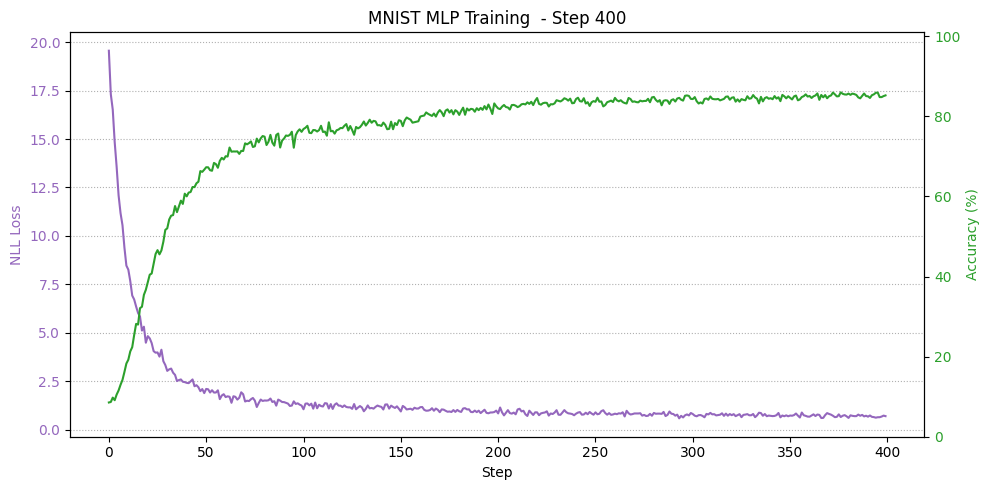

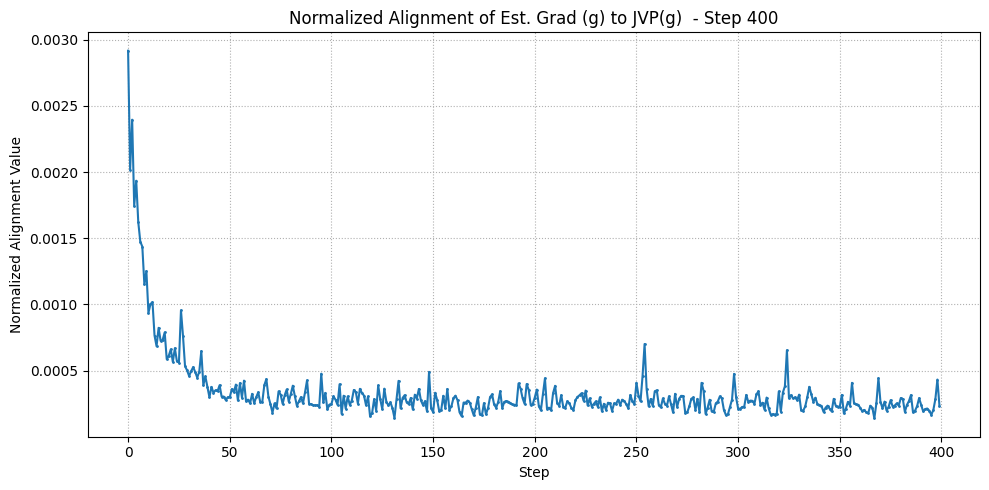


Step 401: Loss 0.6332. Reducing noise density towards target.
    New noise density: 5.97e-06
Step [401/2000], Loss: 0.6332, Acc: 86.02%, Align: 0.0002, NoiseDens: 5.97e-06, Samples: 128

Step 402: Loss 0.6560. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 403: Loss 0.6842. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 404: Loss 0.7593. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 405: Loss 0.6937. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 406: Loss 0.8168. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 407: Loss 0.7153. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 408: Loss 0.7237. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 409: Loss 0.6670. Reducing noise density towards target.
    New noise density: 5.97e-06

Step 410: Loss 0.6113. Reducing noise density towar

KeyboardInterrupt: 

In [ ]:
# -*- coding: utf-8 -*-
"""
lk99_proof_adaptive_loss_samples.py

Complete script demonstrating the algorithm with:
1. Batched JVP computation using torch.func.vmap.
2. Adaptive noise density adjustment based on loss value (starts high, decays).
3. Adaptive sample size increase when noise density becomes low.
4. All necessary helper functions included for standalone execution.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
from collections import deque # Still potentially useful for tracking other metrics if needed

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Helper Functions (Quantization, Noise Generation) ---

def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  # Ensure constants are on the right device or compatible type
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  # Ensure resulting tensor is on the correct device
  level_tensor = tch.tensor(level, device=dev) if not isinstance(level, tch.Tensor) else level.to(dev)
  return tch.where(signal < level_tensor, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

# balanced ternary noise with symbol distribution w = [ -1 = a, 0 = b, +1 = c ]
def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    tch.manual_seed(seed)
    if device == tch.device("cuda"):
        tch.cuda.manual_seed_all(seed)
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

# binary noise mask generation
def rand_mask(shape, p, device=None):
  random_tensor = tch.rand(shape, device=device)
  # Ensure p is compatible (scalar or tensor on the right device)
  p_val = min(max(p, 0.0), 1.0) # Clamp p to [0, 1]
  return lt(random_tensor, p_val, device=device)

def randu():
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

def probs(mean, sparsity = None):
  z_min = max(abs(mean) - 1, 0)
  z_max = min(1 - abs(mean), 1)
  p_z = rand_between(z_min, z_max).item() if sparsity == None else min(max(sparsity, z_min), z_max)
  n_min = max(-mean / 2, 0)
  n_max = min(-(mean - 1) / 2, 1)
  p_n_candidate = (1 - p_z - mean) / 2
  p_n = min(max(p_n_candidate, n_min), n_max)
  p_u = 1.0 - p_n - p_z
  p_n = min(max(p_n, 0.0), 1.0)
  p_z = min(max(p_z, 0.0), 1.0)
  p_u = min(max(p_u, 0.0), 1.0)
  total_p = p_n + p_z + p_u
  if not math.isclose(total_p, 1.0):
      if total_p > 1e-9:
          p_n /= total_p
          p_z /= total_p
          p_u /= total_p
      else:
          p_n, p_z, p_u = 1/3, 1/3, 1/3
  return [p_n, p_z, p_u]

# Generate sign noise (-1, 1) with mean=0
def sign_noise(shape, mean = 0.0, device=None):
  # mean=0 implies equal probability for -1 and +1 if sparsity=0
  return rand_tern(shape, probs(mean, sparsity=0), device=device)

# --- Data Loading ---
def get_batch(batch_size, device):
  transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0).float() # Binarize
  ])
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0
  try:
      # Ensure dataset exists
      mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  except Exception as e:
      print(f"Error downloading or loading MNIST dataset: {e}")
      raise # Re-raise the exception as data is critical

  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size <= 0:
      raise ValueError(f"Batch size must be positive, got {batch_size}")

  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)

  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except RuntimeError as e: # Catch potential DataLoader issues
      print(f"DataLoader error (num_workers={num_workers}), retrying with num_workers=0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))
  except Exception as e:
      print(f"Unexpected error during batch loading: {e}")
      raise # Re-raise other unexpected errors

  data, target = batch
  data = data.to(device, non_blocking=pin_memory)
  target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test batch loading once at the start
try:
    _ = get_batch(1, device)
    print("Batch loading test successful.")
except Exception as e:
    print(f"ERROR: Failed initial batch loading test: {e}")
    # Exit or handle appropriately if data loading fails fundamentally
    exit()

# --- Network Definition ---

def layer_norm(x, eps=1e-5):
  mean = tch.mean(x, dim=-1, keepdim=True)
  var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps)

def total_params(input_size, hidden_size, output_size):
  """Calculates the total number of parameters in the network."""
  ti = 0
  # Layer 1 weights and bias
  ti += input_size * hidden_size
  ti += hidden_size
  # Layer 2 weights and bias
  ti += hidden_size * hidden_size
  ti += hidden_size
  # Layer 3 (Output) weights and bias
  ti += hidden_size * output_size
  ti += output_size
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  """Defines the feedforward network structure."""
  ti = 0

  # Parameter slicing (ensure correct shapes and order)
  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size)
  ti += input_size * hidden_size
  b1 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size)
  ti += hidden_size * hidden_size
  b2 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size)
  ti += hidden_size * output_size
  b3 = t_params[ti:ti + output_size].view(output_size)
  ti += output_size

  # Forward pass
  x = x.view(-1, input_size) # Flatten input

  # Layer 1
  x = x @ w1.t() + b1
  x = layer_norm(x)
  x = F.relu(x)

  # Layer 2
  x = x @ w2.t() + b2
  x = layer_norm(x)
  x = F.relu(x)

  # Output Layer
  x = x @ w3.t() + b3
  output = F.log_softmax(x, dim=1) # Use log_softmax for NLLLoss

  return output

# --- Loss and Accuracy Functions ---

def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  """Calculates the Negative Log Likelihood loss."""
  data, target = batch
  output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  loss = F.nll_loss(output, target.long()) # Ensure target is LongTensor
  return loss

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  """Computes the classification accuracy."""
  data, target = batch
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item()
      total = target.size(0)
  accuracy = 100.0 * correct / total
  return accuracy

# --- Plotting Function ---

def plot(loss_record, acc_record, align_record, title_suffix=""):
    """Plots training loss, accuracy, and alignment."""
    fig, ax1 = plt.subplots(figsize=(10, 5))
    title = f"MNIST MLP Training {title_suffix}"
    plt.title(title)

    color = 'tab:purple'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('NLL Loss', color=color)
    # Filter NaNs before plotting loss
    steps_loss = [i for i, x in enumerate(loss_record) if not np.isnan(x)]
    loss_vals = [x for x in loss_record if not np.isnan(x)]
    ax1.plot(steps_loss, loss_vals, color=color, linestyle='-', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y', linestyle=':')

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    # Filter NaNs before plotting accuracy
    steps_acc = [i for i, x in enumerate(acc_record) if not np.isnan(x)]
    acc_vals = [x for x in acc_record if not np.isnan(x)]
    ax2.plot(steps_acc, acc_vals, color=color, linestyle='-', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 101) # Set explicit bounds for accuracy

    fig.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step")
    plt.ylabel("Normalized Alignment Value")
    steps_align = [i for i, x in enumerate(align_record) if not np.isnan(x)]
    align_vals = [x for x in align_record if not np.isnan(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2)
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512
output_size = 10
initial_samples = 128       # Initial number of perturbations per step
eval_batch_size_factor = 5
eval_batch_max = 10000

# Determine total parameters AFTER defining the function
dim = total_params(input_size, hidden_size, output_size)

# Initialize theta on the target device
theta = rand_tern((dim,), device=device, requires_grad=False)

# --- Noise Density and Sample Size Parameters ---
initial_noise_density = 16 / dim # Start relatively high
noise_density = initial_noise_density
current_samples = initial_samples # Initialize current sample size

# --- Loss-based Decay Parameters for noise_density ---
loss_threshold_1 = 1.0    # First threshold for starting decay
target_density_1 = max(4 / dim, initial_noise_density / 4)
loss_threshold_2 = 0.5    # Second threshold for further decay
target_density_2 = max(1 / dim, initial_noise_density / 16)
# Define absolute minimum density (prevents density becoming too small)
min_abs_noise_density = 1 / dim

# --- Sample Size Increase Parameters ---
density_threshold_increase_samples = 2 / dim # If density drops below this...
sample_increase_factor = 2                 # ...increase samples by this factor (e.g., double)
max_samples = initial_samples * 4          # Upper limit for samples

# Records for plotting
loss_record = []
acc_record = []
align_record = []

print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Initial samples per step (JVP batch): {initial_samples}")
print(f"Max samples per step: {max_samples}")
print(f"Initial noise density: {initial_noise_density:.3e}")
print(f"Noise Density Decay Thresholds: Loss < {loss_threshold_1} -> ~{target_density_1:.2e}, Loss < {loss_threshold_2} -> ~{target_density_2:.2e}")
print(f"Min Absolute Noise Density: {min_abs_noise_density:.2e}")
print(f"Sample Increase Trigger: Density < {density_threshold_increase_samples:.2e}")
print(f"----------------------------")

# Main training loop
for j in tqdm(range(steps), desc="Training Progress"):
    # 1. Get Training Batch
    try:
        batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nERROR getting training batch at step {j}: {e}. Skipping step.")
        loss_record.append(loss_record[-1] if loss_record else float('nan'))
        acc_record.append(acc_record[-1] if acc_record else float('nan'))
        align_record.append(float('nan'))
        continue

    # 2. Define Loss Closure for JVP
    theta.requires_grad_(False) # Ensure theta doesn't track grad for JVP point
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # 3. Batched JVP Computation
    current_loss_tensor = None
    valid_aligns = None
    valid_perturbs = None
    g = tch.zeros_like(theta) # Initialize gradient estimate to zero

    try:
        # Generate perturbations for the current sample size and density
        masks = rand_mask((current_samples, dim), noise_density, device=device)
        s_noises = sign_noise((current_samples, dim), device=device)
        perturbs_batch = s_noises * masks

        # Define the function for vmap
        def single_jvp(tangent_vector):
            l, jvp_val = tch.func.jvp(f, (theta,), (tangent_vector,))
            return l, jvp_val

        # Run vmap
        theta.requires_grad_(False)
        perturbs_batch.requires_grad_(True) # Tangents must require grad
        all_losses, aligns_batch = tch.func.vmap(single_jvp)(perturbs_batch)
        perturbs_batch.requires_grad_(False) # Disable grad after use

        # --- Process JVP Results ---
        valid_indices = tch.isfinite(aligns_batch) & tch.isfinite(all_losses) # Check both
        num_valid = valid_indices.sum().item()

        if num_valid == 0:
            print(f"\nWarning: All {current_samples} JVP results invalid (NaN/Inf) at step {j}. Skipping update.")
            current_loss = float('nan')
        elif num_valid < current_samples:
            print(f"\nWarning: {current_samples - num_valid}/{current_samples} JVP invalid at step {j}. Using {num_valid} valid samples.")
            valid_aligns = aligns_batch[valid_indices]
            valid_perturbs = perturbs_batch[valid_indices]
            # Use the mean loss of valid samples (should be nearly identical)
            current_loss_tensor = all_losses[valid_indices].mean()
            current_loss = current_loss_tensor.item() if tch.isfinite(current_loss_tensor) else float('nan')
        else:
            # All results are valid
            valid_aligns = aligns_batch
            valid_perturbs = perturbs_batch
            current_loss_tensor = all_losses.mean() # Use mean loss
            current_loss = current_loss_tensor.item()

        # 4. Gradient Estimation (only if valid results exist)
        if valid_aligns is not None and valid_aligns.numel() > 0:
            median = tch.median(valid_aligns.abs())
            # Avoid division by zero if median is zero
            safe_median = max(median.item(), 1e-9) * tch.ones_like(median)

            align_terns = valid_aligns.sign() * tch.where(valid_aligns.abs() >= safe_median,
                                                          tch.tensor(1.0, device=device),
                                                          tch.tensor(0.0, device=device))
            g_nontern = tch.sum(valid_perturbs * align_terns[:,None], dim=0)
            g = quant(g_nontern) # Quantize the summed gradient estimate
        elif np.isfinite(current_loss): # Only warn if loss calculation itself was okay
             print(f"Step {j}: No valid alignments. Using zero gradient.")

    except Exception as e:
        print(f"\nERROR during batched JVP or Grad Estimation at step {j}: {e}")
        # Log NaNs and attempt to continue
        current_loss = float('nan')
        acc = float('nan')
        true_algn = float('nan')
        # Skip update-related steps, proceed to logging/next iteration
        loss_record.append(current_loss)
        acc_record.append(acc)
        align_record.append(true_algn)
        # Reset grad requires flags if error occurred mid-computation
        if 'perturbs_batch' in locals() and perturbs_batch.requires_grad: perturbs_batch.requires_grad_(False)
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
        continue # Skip the rest of the loop for this step

    # 5. Accuracy Calculation
    acc = float('nan') # Default to NaN
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000)
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size)
    except Exception as e:
        print(f"\nWarning: Error getting eval batch or computing accuracy at step {j}: {e}")


    # 6. Alignment Check (using the estimated gradient g)
    true_algn = float('nan') # Default to NaN
    if tch.count_nonzero(g) > 0:
        try:
            g.requires_grad_(True) # grad needed for tangent in JVP
            theta.requires_grad_(False)
            _, true_algn_tensor = tch.func.jvp(f,(theta,),(g,))
            g.requires_grad_(False) # Turn off grad after use

            # Normalize alignment - use L1 norm of g primarily
            norm_factor = tch.linalg.norm(g, ord=1).item()
            # Fallback normalization: use expected magnitude based on density and samples
            if norm_factor < 1e-9:
                # Estimate expected L1 norm: samples * density * dim? Maybe just density * dim
                norm_factor = max(dim * noise_density, 1e-6)
                # print(f"Step {j} Align Norm Fallback: {norm_factor:.2e}") # Debug print

            true_algn = true_algn_tensor.item() / norm_factor
            if not np.isfinite(true_algn):
                 print(f"\nWarning: Alignment calculation resulted in NaN/Inf at step {j}. Norm factor: {norm_factor:.2e}, JVP: {true_algn_tensor.item():.2e}")
                 true_algn = float('nan')

        except Exception as e:
            print(f"\nWarning: Error during alignment JVP (checking g) at step {j}: {e}")
            if 'g' in locals() and g.requires_grad: g.requires_grad_(False) # Ensure grad is off
    else:
        true_algn = 0.0 # Zero alignment if gradient estimate is zero


    # 7. Parameter Update
    with tch.no_grad(): # Ensure no gradient tracking during update
        theta = quant(theta - g) # Update happens on device


    # 8. Record Metrics (handle NaNs)
    loss_record.append(current_loss if np.isfinite(current_loss) else float('nan'))
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))


    # 9. Adapt Noise Density (Based on Loss)
    old_noise_density = noise_density
    density_changed = False
    if np.isfinite(current_loss):
        target_density = noise_density # Start with current density
        if current_loss < loss_threshold_1:
            target_density = min(target_density, target_density_1)
        if current_loss < loss_threshold_2:
            target_density = min(target_density, target_density_2)

        # Only update if the target is lower than current density
        if target_density < noise_density:
            # Approach the target density gradually (e.g., move 10% closer each step)
            noise_density = noise_density * 0.9 + target_density * 0.1
            # noise_density = target_density # Or jump directly
            density_changed = True

        # Clamp to absolute minimum
        noise_density = max(noise_density, min_abs_noise_density)
        if noise_density != old_noise_density and density_changed:
            print(f"\nStep {j+1}: Loss {current_loss:.4f}. Reducing noise density towards target.")
            print(f"    New noise density: {noise_density:.2e}")

    # 10. Adapt Sample Size (Based on New Density)
    old_samples = current_samples
    samples_changed = False
    if noise_density < density_threshold_increase_samples:
        target_samples = min(int(initial_samples * sample_increase_factor), max_samples)
        if target_samples > current_samples:
             current_samples = target_samples
             samples_changed = True
    else:
        # Option: Gradually decrease samples back to initial if density increases?
        # current_samples = max(initial_samples, int(current_samples * 0.98))
        pass # Keep samples high once increased, or reset immediately:
        # current_samples = initial_samples # Reset if density is high enough

    if samples_changed:
        print(f"Step {j+1}: Noise density low ({noise_density:.2e}). Increasing samples to {current_samples}.")


    # 11. Print Progress
    if j % 20 == 0 or j == steps - 1:
        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"
        print(f"Step [{j+1}/{steps}], Loss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}, Samples: {current_samples}")

    # 12. Plot Periodically
    if (j + 1) % 400 == 0 and j > 0:
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---

CUDA available. Using GPU: Tesla T4
Batch loading test successful.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Initial samples: 32, Max samples: 256
Initial noise density: 9.556e-05 (Factor: 4.0x Base)
Loss Decay Threshold: 0.5, Target Noise Density: 1.49e-06
Min Noise Density: 1.49e-06
Sample Increase Factor (on decay): 1.05
Loss Rate Window: 25
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Step [1/2000], Loss: 19.2951, Acc: 11.05%, Align: 0.0017, NoiseDens: 9.56e-05, Samples: 32
Step [21/2000], Loss: 8.4340, Acc: 17.30%, Align: 0.0008, NoiseDens: 9.56e-05, Samples: 32
Step [41/2000], Loss: 4.2678, Acc: 40.90%, Align: 0.0003, NoiseDens: 9.56e-05, Samples: 32
Step [61/2000], Loss: 3.1348, Acc: 53.01%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [81/2000], Loss: 2.5628, Acc: 58.57%, Align: 0.0003, NoiseDens: 9.56e-05, Samples: 32
Step [101/2000], Loss: 2.2159, Acc: 61.86%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [121/2000], Loss: 1.9974, Acc: 65.51%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [141/2000], Loss: 1.8126, Acc: 69.34%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32
Step [161/2000], Loss: 1.5761, Acc: 69.98%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [181/2000], Loss: 1.4700, Acc: 72.73%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32
Step [201/2000], Loss: 1.4423, Acc: 73.54%, Align: 0.0002, NoiseDens: 9.56e-05, Sampl

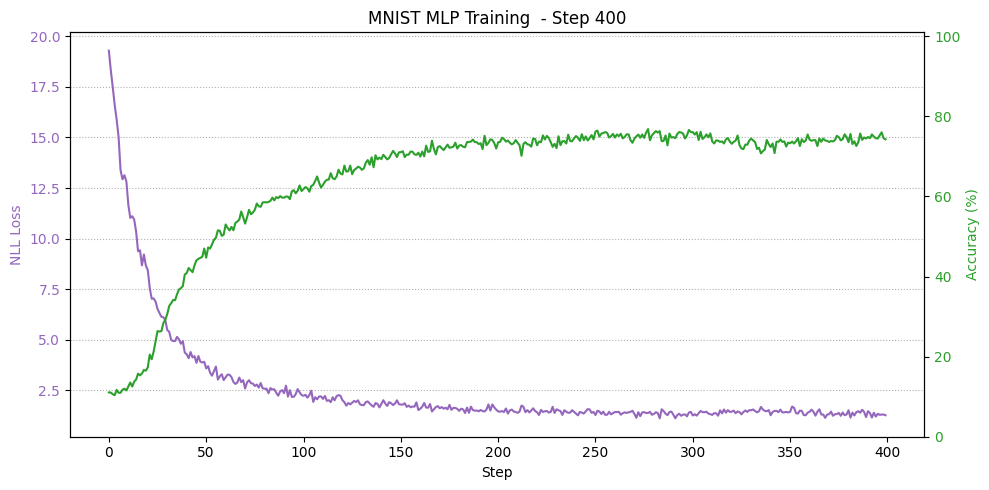

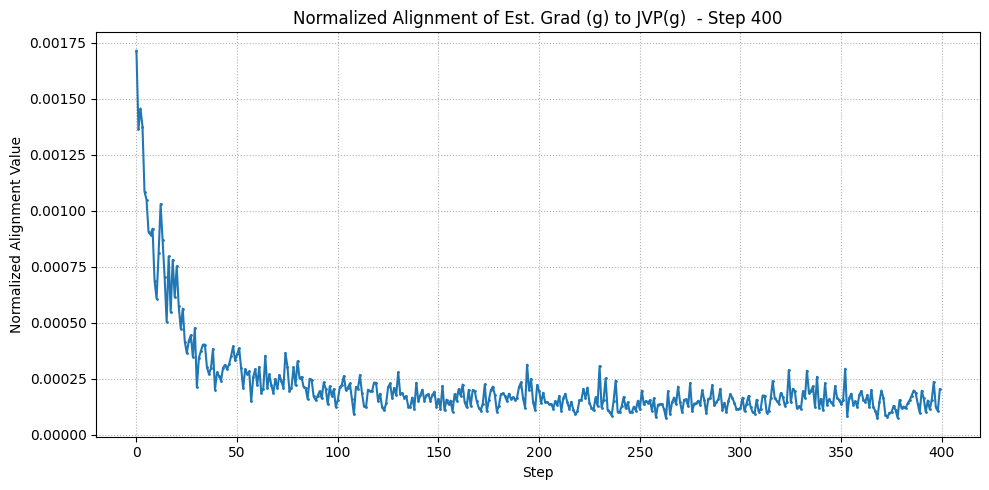

Step [401/2000], Loss: 1.1749, Acc: 75.55%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32
Step [421/2000], Loss: 1.3275, Acc: 76.00%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [441/2000], Loss: 1.3054, Acc: 75.66%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [461/2000], Loss: 1.3080, Acc: 74.08%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [481/2000], Loss: 1.3368, Acc: 74.90%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [501/2000], Loss: 1.4345, Acc: 74.51%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32
Step [521/2000], Loss: 1.3615, Acc: 76.43%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32


KeyboardInterrupt: 

In [ ]:
# -*- coding: utf-8 -*-
"""
lk99_proof_adaptive_loss_rate_sync.py

Complete script demonstrating the algorithm with:
1. Batched JVP computation using torch.func.vmap.
2. Adaptive noise density:
    - Starts higher density, lower samples.
    - Decays towards a target density based on loss value AND loss decrease rate.
3. Adaptive sample size:
    - Increases simultaneously with noise density decay.
4. All necessary helper functions included for standalone execution.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
from collections import deque # For tracking loss history

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Helper Functions (Quantization, Noise Generation) ---

def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  level_tensor = tch.tensor(level, device=dev) if not isinstance(level, tch.Tensor) else level.to(dev)
  return tch.where(signal < level_tensor, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    tch.manual_seed(seed)
    if device == tch.device("cuda"):
        tch.cuda.manual_seed_all(seed)
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

def rand_mask(shape, p, device=None):
  random_tensor = tch.rand(shape, device=device)
  p_val = min(max(p, 0.0), 1.0)
  return lt(random_tensor, p_val, device=device)

def randu():
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

def probs(mean, sparsity = None):
  z_min = max(abs(mean) - 1, 0)
  z_max = min(1 - abs(mean), 1)
  p_z = rand_between(z_min, z_max).item() if sparsity == None else min(max(sparsity, z_min), z_max)
  n_min = max(-mean / 2, 0)
  n_max = min(-(mean - 1) / 2, 1)
  p_n_candidate = (1 - p_z - mean) / 2
  p_n = min(max(p_n_candidate, n_min), n_max)
  p_u = 1.0 - p_n - p_z
  p_n = min(max(p_n, 0.0), 1.0); p_z = min(max(p_z, 0.0), 1.0); p_u = min(max(p_u, 0.0), 1.0)
  total_p = p_n + p_z + p_u
  if not math.isclose(total_p, 1.0):
      if total_p > 1e-9: p_n /= total_p; p_z /= total_p; p_u /= total_p
      else: p_n, p_z, p_u = 1/3, 1/3, 1/3
  return [p_n, p_z, p_u]

def sign_noise(shape, mean = 0.0, device=None):
  return rand_tern(shape, probs(mean, sparsity=0), device=device)

# --- Data Loading ---
def get_batch(batch_size, device):
  transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()])
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0
  try:
      mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  except Exception as e:
      print(f"Error loading MNIST dataset: {e}"); raise
  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size <= 0: raise ValueError(f"Batch size must be positive, got {batch_size}")
  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)
  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except RuntimeError as e:
      print(f"DataLoader error (num_workers={num_workers}), retrying with 0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))
  except Exception as e: print(f"Unexpected batch loading error: {e}"); raise
  data, target = batch
  data = data.to(device, non_blocking=pin_memory)
  target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test batch loading
try: _ = get_batch(1, device); print("Batch loading test successful.")
except Exception as e: print(f"ERROR: Failed initial batch loading test: {e}"); exit()

# --- Network Definition ---
def layer_norm(x, eps=1e-5):
  mean = tch.mean(x, dim=-1, keepdim=True); var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps)

def total_params(input_size, hidden_size, output_size):
  ti = 0; ti += input_size * hidden_size + hidden_size # Layer 1
  ti += hidden_size * hidden_size + hidden_size       # Layer 2
  ti += hidden_size * output_size + output_size       # Layer 3
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  ti = 0
  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size); ti += input_size * hidden_size
  b1 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size); ti += hidden_size * hidden_size
  b2 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size); ti += hidden_size * output_size
  b3 = t_params[ti:ti + output_size].view(output_size); ti += output_size
  x = x.view(-1, input_size)
  x = F.relu(layer_norm(x @ w1.t() + b1)) # Layer 1
  x = F.relu(layer_norm(x @ w2.t() + b2)) # Layer 2
  output = F.log_softmax(x @ w3.t() + b3, dim=1) # Output
  return output

# --- Loss and Accuracy Functions ---
def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch; output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  return F.nll_loss(output, target.long())

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item(); total = target.size(0)
  return 100.0 * correct / total

# --- Plotting Function ---
def plot(loss_record, acc_record, align_record, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 5)); title = f"MNIST MLP Training {title_suffix}"; plt.title(title)
    color = 'tab:purple'; ax1.set_xlabel('Step'); ax1.set_ylabel('NLL Loss', color=color)
    steps_loss = [i for i, x in enumerate(loss_record) if np.isfinite(x)]
    loss_vals = [x for x in loss_record if np.isfinite(x)]
    ax1.plot(steps_loss, loss_vals, color=color, linestyle='-', label='Loss'); ax1.tick_params(axis='y', labelcolor=color); ax1.grid(True, axis='y', linestyle=':')
    ax2 = ax1.twinx(); color = 'tab:green'; ax2.set_ylabel('Accuracy (%)', color=color)
    steps_acc = [i for i, x in enumerate(acc_record) if np.isfinite(x)]
    acc_vals = [x for x in acc_record if np.isfinite(x)]
    ax2.plot(steps_acc, acc_vals, color=color, linestyle='-', label='Accuracy'); ax2.tick_params(axis='y', labelcolor=color); ax2.set_ylim(0, 101)
    fig.tight_layout(); plt.show()
    plt.figure(figsize=(10, 5)); plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step"); plt.ylabel("Normalized Alignment Value")
    steps_align = [i for i, x in enumerate(align_record) if np.isfinite(x)]
    align_vals = [x for x in align_record if np.isfinite(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2); plt.grid(True, linestyle=':'); plt.tight_layout(); plt.show()

# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512
output_size = 10
eval_batch_size_factor = 5
eval_batch_max = 10000

# Determine total parameters
dim = total_params(input_size, hidden_size, output_size)

# --- Adaptive Parameters ---
initial_noise_density_factor = 4.0 # Multiplier for the base density (e.g., 4 * 16/dim)
initial_samples = 32             # Start with fewer samples
max_samples = initial_samples * 8  # Max samples (e.g., 32 * 8 = 256)

# Noise Density Decay Control
loss_decay_threshold = 0.5       # Loss value below which decay *can* start
target_noise_density = max(1 / dim, (16 / dim) / 16) # Final target density
min_abs_noise_density = 1 / dim    # Absolute minimum density
noise_decay_step_factor = 0.95   # How much to move towards target density per step (e.g., 5% closer)

# Loss Rate Calculation
loss_rate_window = 25           # Number of steps to average loss rate over
min_loss_decrease_rate = 1e-5   # Minimum avg decrease rate to trigger density decay

# Sample Size Increase Control (synchronized with density decay)
sample_increase_factor_on_decay = 1.05 # Multiplicative factor for samples when density decays

# Initialize theta
theta = rand_tern((dim,), device=device, requires_grad=False)

# Initialize adaptive variables
base_density = 16 / dim
initial_noise_density = min(1.0, base_density * initial_noise_density_factor) # Clamp initial density <= 1.0
noise_density = initial_noise_density
current_samples = initial_samples

# Records and history
loss_record = []
acc_record = []
align_record = []
loss_history = deque(maxlen=loss_rate_window)

print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Initial samples: {initial_samples}, Max samples: {max_samples}")
print(f"Initial noise density: {initial_noise_density:.3e} (Factor: {initial_noise_density_factor}x Base)")
print(f"Loss Decay Threshold: {loss_decay_threshold}, Target Noise Density: {target_noise_density:.2e}")
print(f"Min Noise Density: {min_abs_noise_density:.2e}")
print(f"Sample Increase Factor (on decay): {sample_increase_factor_on_decay}")
print(f"Loss Rate Window: {loss_rate_window}")
print(f"----------------------------")

# Main training loop
for j in tqdm(range(steps), desc="Training Progress"):
    # 1. Get Training Batch
    try: batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nERROR getting training batch at step {j}: {e}. Skipping.")
        loss_record.append(loss_record[-1] if loss_record else float('nan'))
        acc_record.append(acc_record[-1] if acc_record else float('nan'))
        align_record.append(float('nan')); loss_history.append(float('nan'))
        continue

    # 2. Define Loss Closure
    theta.requires_grad_(False)
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # 3. Batched JVP
    current_loss = float('nan'); g = tch.zeros_like(theta) # Defaults
    try:
        masks = rand_mask((current_samples, dim), noise_density, device=device)
        s_noises = sign_noise((current_samples, dim), device=device)
        perturbs_batch = s_noises * masks

        def single_jvp(tangent_vector):
            l, jvp_val = tch.func.jvp(f, (theta,), (tangent_vector,))
            return l, jvp_val

        theta.requires_grad_(False); perturbs_batch.requires_grad_(True)
        all_losses, aligns_batch = tch.func.vmap(single_jvp)(perturbs_batch)
        perturbs_batch.requires_grad_(False)

        valid_indices = tch.isfinite(aligns_batch) & tch.isfinite(all_losses)
        num_valid = valid_indices.sum().item()

        if num_valid == 0: print(f"\nWarning: All {current_samples} JVP invalid at step {j}.")
        else:
            if num_valid < current_samples: print(f"\nWarning: {current_samples - num_valid}/{current_samples} JVP invalid at step {j}.")
            valid_aligns = aligns_batch[valid_indices]; valid_perturbs = perturbs_batch[valid_indices]
            current_loss_tensor = all_losses[valid_indices].mean()
            current_loss = current_loss_tensor.item()

            # 4. Gradient Estimation
            if valid_aligns.numel() > 0:
                median = tch.median(valid_aligns.abs())
                safe_median = max(median.item(), 1e-9) * tch.ones_like(median)
                align_terns = valid_aligns.sign() * tch.where(valid_aligns.abs() >= safe_median, 1.0, 0.0)
                g_nontern = tch.sum(valid_perturbs * align_terns[:,None], dim=0)
                g = quant(g_nontern)
            elif np.isfinite(current_loss): print(f"Step {j}: No valid alignments. Using zero gradient.")

    except Exception as e:
        print(f"\nERROR during JVP/Grad Est at step {j}: {e}")
        current_loss = float('nan'); acc = float('nan'); true_algn = float('nan')
        loss_record.append(current_loss); acc_record.append(acc); align_record.append(true_algn); loss_history.append(current_loss)
        if 'perturbs_batch' in locals() and perturbs_batch.requires_grad: perturbs_batch.requires_grad_(False)
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
        continue

    # 5. Accuracy Calculation
    acc = float('nan')
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000)
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size)
    except Exception as e: print(f"\nWarning: Error during accuracy calculation at step {j}: {e}")

    # 6. Alignment Check
    true_algn = float('nan')
    if tch.count_nonzero(g) > 0:
        try:
            g.requires_grad_(True); theta.requires_grad_(False)
            _, true_algn_tensor = tch.func.jvp(f,(theta,),(g,))
            g.requires_grad_(False)
            norm_factor = tch.linalg.norm(g, ord=1).item()
            if norm_factor < 1e-9: norm_factor = max(dim * noise_density, 1e-6)
            true_algn = true_algn_tensor.item() / norm_factor
            if not np.isfinite(true_algn): true_algn = float('nan')
        except Exception as e: print(f"\nWarning: Error during alignment JVP at step {j}: {e}")
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
    else: true_algn = 0.0

    # 7. Parameter Update
    with tch.no_grad(): theta = quant(theta - g)

    # 8. Record Metrics
    loss_to_record = current_loss if np.isfinite(current_loss) else float('nan')
    loss_record.append(loss_to_record)
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))
    loss_history.append(loss_to_record) # Add current loss (or NaN) to history

    # 9. & 10. Adapt Noise Density and Sample Size
    density_changed = False
    samples_changed = False
    if len(loss_history) == loss_rate_window and np.isfinite(current_loss):
        # Calculate average loss decrease rate from valid history points
        valid_losses = [l for l in loss_history if np.isfinite(l)]
        if len(valid_losses) >= loss_rate_window // 2: # Need sufficient history
            avg_loss_decrease = -np.mean(np.diff(valid_losses)) # Negative diff for decrease

            # Check conditions for decay: below loss threshold AND loss is decreasing
            if current_loss < loss_decay_threshold and avg_loss_decrease > min_loss_decrease_rate:
                old_noise_density = noise_density
                old_samples = current_samples

                # Decay noise density towards target
                noise_density = noise_density * noise_decay_step_factor + target_noise_density * (1 - noise_decay_step_factor)
                noise_density = max(noise_density, min_abs_noise_density) # Clamp minimum

                if noise_density < old_noise_density: # Check if density actually decreased
                    density_changed = True
                    # Increase samples simultaneously
                    current_samples = min(max_samples, int(current_samples * sample_increase_factor_on_decay) + 1) # Add 1 to ensure increase
                    if current_samples > old_samples:
                        samples_changed = True

    # Print update messages if changes occurred
    if density_changed:
        print(f"\nStep {j+1}: Loss {current_loss:.4f} < {loss_decay_threshold}, decreasing. Adapting dynamics.")
        print(f"    Noise density decayed to: {noise_density:.2e}")
    if samples_changed:
        print(f"    Sample size increased to: {current_samples}")


    # 11. Print Progress
    if j % 20 == 0 or j == steps - 1:
        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"
        print(f"Step [{j+1}/{steps}], Loss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}, Samples: {current_samples}")

    # 12. Plot Periodically
    if (j + 1) % 400 == 0 and j > 0:
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---

In [ ]:
# -*- coding: utf-8 -*-
"""
lk99_proof_reactive_loss_increase.py

Complete script demonstrating the algorithm with:
1. Batched JVP computation using torch.func.vmap.
2. Reactive adaptation:
    - If loss increases compared to the previous step:
        - Halve noise density (respecting minimum).
        - Double sample size (respecting maximum).
3. Higher initial noise density and low initial samples.
4. All necessary helper functions included for standalone execution.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
# No longer need deque for loss history

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Helper Functions (Quantization, Noise Generation) ---
# (Keeping these functions as they are essential)
def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  level_tensor = tch.tensor(level, device=dev) if not isinstance(level, tch.Tensor) else level.to(dev)
  return tch.where(signal < level_tensor, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    tch.manual_seed(seed)
    if device == tch.device("cuda"): tch.cuda.manual_seed_all(seed)
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

def rand_mask(shape, p, device=None):
  random_tensor = tch.rand(shape, device=device)
  p_val = min(max(p, 0.0), 1.0)
  return lt(random_tensor, p_val, device=device)

def sign_noise(shape, mean = 0.0, device=None):
  # Mean=0 implies equal prob for -1 and +1 if sparsity=0
  # For ternary noise [-1, 0, +1], this function generates {-1, +1} based on probs()
  # If you need purely {-1, +1}, modify probs or use a different generator.
  # Current implementation with mean=0, sparsity=0 gives w=[0.5, 0, 0.5] -> {-1, +1} noise
  return rand_tern(shape, probs(mean, sparsity=0), device=device)

# --- Data Loading ---
def get_batch(batch_size, device):
  transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()])
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0
  try: mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  except Exception as e: print(f"Error loading MNIST dataset: {e}"); raise
  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size <= 0: raise ValueError(f"Batch size must be positive, got {batch_size}")
  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)
  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except RuntimeError as e:
      print(f"DataLoader error (num_workers={num_workers}), retrying with 0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))
  except Exception as e: print(f"Unexpected batch loading error: {e}"); raise
  data, target = batch
  data = data.to(device, non_blocking=pin_memory); target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test batch loading
try: _ = get_batch(1, device); print("Batch loading test successful.")
except Exception as e: print(f"ERROR: Failed initial batch loading test: {e}"); exit()

# --- Network Definition ---
def layer_norm(x, eps=1e-5):
  mean = tch.mean(x, dim=-1, keepdim=True); var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps)

def total_params(input_size, hidden_size, output_size):
  ti = 0; ti += input_size * hidden_size + hidden_size # Layer 1
  ti += hidden_size * hidden_size + hidden_size       # Layer 2
  ti += hidden_size * output_size + output_size       # Layer 3
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  ti = 0
  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size); ti += input_size * hidden_size
  b1 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size); ti += hidden_size * hidden_size
  b2 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size); ti += hidden_size * output_size
  b3 = t_params[ti:ti + output_size].view(output_size); ti += output_size
  x = x.view(-1, input_size)
  x = F.relu(layer_norm(x @ w1.t() + b1)) # Layer 1
  x = F.relu(layer_norm(x @ w2.t() + b2)) # Layer 2
  output = F.log_softmax(x @ w3.t() + b3, dim=1) # Output
  return output

# --- Loss and Accuracy Functions ---
def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch; output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  return F.nll_loss(output, target.long())

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item(); total = target.size(0)
  return 100.0 * correct / total

# --- Plotting Function ---
# (Keeping plotting function as is)
def plot(loss_record, acc_record, align_record, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 5)); title = f"MNIST MLP Training {title_suffix}"; plt.title(title)
    color = 'tab:purple'; ax1.set_xlabel('Step'); ax1.set_ylabel('NLL Loss', color=color)
    steps_loss = [i for i, x in enumerate(loss_record) if np.isfinite(x)]
    loss_vals = [x for x in loss_record if np.isfinite(x)]
    ax1.plot(steps_loss, loss_vals, color=color, linestyle='-', label='Loss'); ax1.tick_params(axis='y', labelcolor=color); ax1.grid(True, axis='y', linestyle=':')
    ax2 = ax1.twinx(); color = 'tab:green'; ax2.set_ylabel('Accuracy (%)', color=color)
    steps_acc = [i for i, x in enumerate(acc_record) if np.isfinite(x)]
    acc_vals = [x for x in acc_record if np.isfinite(x)]
    ax2.plot(steps_acc, acc_vals, color=color, linestyle='-', label='Accuracy'); ax2.tick_params(axis='y', labelcolor=color); ax2.set_ylim(0, 101)
    fig.tight_layout(); plt.show()
    plt.figure(figsize=(10, 5)); plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step"); plt.ylabel("Normalized Alignment Value")
    steps_align = [i for i, x in enumerate(align_record) if np.isfinite(x)]
    align_vals = [x for x in align_record if np.isfinite(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2); plt.grid(True, linestyle=':'); plt.tight_layout(); plt.show()


# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512
output_size = 10
eval_batch_size_factor = 5
eval_batch_max = 10000

# Determine total parameters
dim = total_params(input_size, hidden_size, output_size)

# --- Adaptive Parameters ---
initial_noise_density_factor = 8.0 # Further increased initial density (e.g., 8 * 16/dim)
initial_samples = 16             # Start with 16 samples
max_samples = initial_samples * 16 # Max samples (e.g., 16 * 16 = 256) - adjust as needed
min_abs_noise_density = 1 / dim    # Absolute minimum density

# Initialize theta
theta = rand_tern((dim,), device=device, requires_grad=False)

# Initialize adaptive variables
base_density = 16 / dim
initial_noise_density = min(1.0, base_density * initial_noise_density_factor) # Clamp initial density <= 1.0
noise_density = initial_noise_density
current_samples = initial_samples

# Records and state for adaptation
loss_record = []
acc_record = []
align_record = []
last_finite_loss = float('inf') # Store the last valid loss for comparison

print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Initial samples: {initial_samples}, Max samples: {max_samples}")
print(f"Initial noise density: {initial_noise_density:.3e} (Factor: {initial_noise_density_factor}x Base)")
print(f"Min Absolute Noise Density: {min_abs_noise_density:.2e}")
print(f"Adaptation Rule: If Loss Increases -> Halve Density, Double Samples")
print(f"----------------------------")

# Main training loop
for j in tqdm(range(steps), desc="Training Progress"):
    # 1. Get Training Batch
    try: batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nERROR getting training batch at step {j}: {e}. Skipping.")
        loss_record.append(loss_record[-1] if loss_record else float('nan'))
        acc_record.append(acc_record[-1] if acc_record else float('nan'))
        align_record.append(float('nan'))
        # Don't update last_finite_loss if batch loading fails
        continue

    # 2. Define Loss Closure
    theta.requires_grad_(False)
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # 3. Batched JVP
    current_loss = float('nan'); g = tch.zeros_like(theta) # Defaults
    try:
        masks = rand_mask((current_samples, dim), noise_density, device=device)
        s_noises = sign_noise((current_samples, dim), device=device)
        perturbs_batch = s_noises * masks

        def single_jvp(tangent_vector):
            l, jvp_val = tch.func.jvp(f, (theta,), (tangent_vector,))
            return l, jvp_val

        theta.requires_grad_(False); perturbs_batch.requires_grad_(True)
        all_losses, aligns_batch = tch.func.vmap(single_jvp)(perturbs_batch)
        perturbs_batch.requires_grad_(False)

        valid_indices = tch.isfinite(aligns_batch) & tch.isfinite(all_losses)
        num_valid = valid_indices.sum().item()

        if num_valid == 0: print(f"\nWarning: All {current_samples} JVP invalid at step {j}.")
        else:
            if num_valid < current_samples: print(f"\nWarning: {current_samples - num_valid}/{current_samples} JVP invalid at step {j}.")
            valid_aligns = aligns_batch[valid_indices]; valid_perturbs = perturbs_batch[valid_indices]
            current_loss_tensor = all_losses[valid_indices].mean()
            current_loss = current_loss_tensor.item() # Get the current loss value

            # 4. Gradient Estimation
            if valid_aligns.numel() > 0:
                median = tch.median(valid_aligns.abs())
                safe_median = max(median.item(), 1e-9) * tch.ones_like(median)
                # Ensure align_terns values are explicitly float
                align_terns = valid_aligns.sign() * tch.where(valid_aligns.abs() >= safe_median,
                                                              tch.tensor(1.0, device=device),
                                                              tch.tensor(0.0, device=device))
                g_nontern = tch.sum(valid_perturbs * align_terns[:,None], dim=0)
                g = quant(g_nontern)
            elif np.isfinite(current_loss): print(f"Step {j}: No valid alignments. Using zero gradient.")

    except Exception as e:
        print(f"\nERROR during JVP/Grad Est at step {j}: {e}")
        current_loss = float('nan'); acc = float('nan'); true_algn = float('nan')
        loss_record.append(current_loss); acc_record.append(acc); align_record.append(true_algn)
        # Don't update last_finite_loss on JVP error
        if 'perturbs_batch' in locals() and perturbs_batch.requires_grad: perturbs_batch.requires_grad_(False)
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
        continue

    # 5. Accuracy Calculation
    acc = float('nan')
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000)
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size)
    except Exception as e: print(f"\nWarning: Error during accuracy calculation at step {j}: {e}")

    # 6. Alignment Check
    true_algn = float('nan')
    if tch.count_nonzero(g) > 0:
        try:
            g.requires_grad_(True); theta.requires_grad_(False)
            _, true_algn_tensor = tch.func.jvp(f,(theta,),(g,))
            g.requires_grad_(False)
            norm_factor = tch.linalg.norm(g, ord=1).item()
            if norm_factor < 1e-9: norm_factor = max(dim * noise_density, 1e-6)
            true_algn = true_algn_tensor.item() / norm_factor
            if not np.isfinite(true_algn): true_algn = float('nan')
        except Exception as e: print(f"\nWarning: Error during alignment JVP at step {j}: {e}")
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
    else: true_algn = 0.0

    # 7. Parameter Update
    with tch.no_grad(): theta = quant(theta - g)

    # 8. Record Metrics
    loss_to_record = current_loss if np.isfinite(current_loss) else float('nan')
    loss_record.append(loss_to_record)
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))

    # --- 9. Reactive Adaptation based on Loss Increase ---
    density_changed = False
    samples_changed = False
    # Only adapt if current loss and previous loss are valid numbers
    if np.isfinite(current_loss) and np.isfinite(last_finite_loss):
        if current_loss > last_finite_loss:
            # Loss increased, react!
            old_noise_density = noise_density
            old_samples = current_samples

            # Halve noise density
            noise_density /= 2.0
            noise_density = max(noise_density, min_abs_noise_density) # Apply minimum limit

            # Double sample size
            current_samples *= 2
            current_samples = min(current_samples, max_samples) # Apply maximum limit
            current_samples = int(current_samples) # Ensure integer

            # Check if values actually changed
            if noise_density < old_noise_density: density_changed = True
            if current_samples > old_samples: samples_changed = True

            if density_changed or samples_changed:
                 print(f"\nStep {j+1}: Loss increased ({last_finite_loss:.4f} -> {current_loss:.4f}). Reacting.")
                 if density_changed: print(f"    Noise density halved to: {noise_density:.2e}")
                 if samples_changed: print(f"    Sample size doubled to: {current_samples}")

    # Update last_finite_loss for the next iteration *only if* current_loss is finite
    if np.isfinite(current_loss):
        last_finite_loss = current_loss
    # -----------------------------------------------------

    # 10. Print Progress (Reflects state *before* next step's potential adaptation)
    if j % 20 == 0 or j == steps - 1:
        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"
        # Print the density and samples that *were used* for this step j
        print(f"Step [{j+1}/{steps}], Loss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}, Samples: {current_samples}") # Show current state

    # 11. Plot Periodically
    if (j + 1) % 400 == 0 and j > 0:
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---

CUDA available. Using GPU: Tesla T4
Batch loading test successful.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Initial samples: 16, Max samples: 256
Initial noise density: 1.911e-04 (Factor: 8.0x Base)
Min Absolute Noise Density: 1.49e-06
Adaptation Rule: If Loss Increases -> Halve Density, Double Samples
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Step [1/2000], Loss: 15.2797, Acc: 12.54%, Align: 0.0015, NoiseDens: 1.91e-04, Samples: 16

Step 5: Loss increased (13.5413 -> 13.7235). Reacting.
    Noise density halved to: 9.56e-05
    Sample size doubled to: 32

Step 11: Loss increased (10.9804 -> 11.3772). Reacting.
    Noise density halved to: 4.78e-05
    Sample size doubled to: 64
Step [21/2000], Loss: 7.5912, Acc: 26.35%, Align: 0.0008, NoiseDens: 4.78e-05, Samples: 64

Step 25: Loss increased (5.9718 -> 6.1315). Reacting.
    Noise density halved to: 2.39e-05
    Sample size doubled to: 128

Step 27: Loss increased (5.7776 -> 5.8602). Reacting.
    Noise density halved to: 1.19e-05
    Sample size doubled to: 256

Step 38: Loss increased (3.0939 -> 3.2092). Reacting.
    Noise density halved to: 5.97e-06

Step 41: Loss increased (2.8682 -> 2.9169). Reacting.
    Noise density halved to: 2.99e-06
Step [41/2000], Loss: 2.9169, Acc: 56.07%, Align: 0.0006, NoiseDens: 2.99e-06, Samples: 256

Step 45: Loss increased (2.4655 -> 2.6

KeyboardInterrupt: 

CUDA available. Using GPU: Tesla T4
Batch loading test successful.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Initial samples: 16, Max samples: 256
Initial noise density: 1.911e-04 (Factor: 8.0x Base)
Min Absolute Noise Density: 1.49e-06
Adaptation Rule: Every 20 steps, if avg loss increased -> Halve Density, Double Samples
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exc

Step [20/2000], WinAvgLoss: 18.7020, CurLoss: 14.0986, Acc: 14.43%, Align: 0.0007, NoiseDens: 1.91e-04, Samples: 16
Step [40/2000], WinAvgLoss: 10.6653, CurLoss: 7.7974, Acc: 23.85%, Align: 0.0004, NoiseDens: 1.91e-04, Samples: 16
Step [60/2000], WinAvgLoss: 5.9300, CurLoss: 5.2369, Acc: 33.81%, Align: 0.0003, NoiseDens: 1.91e-04, Samples: 16
Step [80/2000], WinAvgLoss: 4.6771, CurLoss: 4.2920, Acc: 43.38%, Align: 0.0003, NoiseDens: 1.91e-04, Samples: 16
Step [100/2000], WinAvgLoss: 3.4803, CurLoss: 3.2611, Acc: 52.19%, Align: 0.0001, NoiseDens: 1.91e-04, Samples: 16
Step [120/2000], WinAvgLoss: 3.0222, CurLoss: 2.8961, Acc: 56.82%, Align: 0.0002, NoiseDens: 1.91e-04, Samples: 16
Step [140/2000], WinAvgLoss: 2.5902, CurLoss: 2.4821, Acc: 60.72%, Align: 0.0001, NoiseDens: 1.91e-04, Samples: 16
Step [160/2000], WinAvgLoss: 2.2690, CurLoss: 2.1423, Acc: 64.41%, Align: 0.0001, NoiseDens: 1.91e-04, Samples: 16
Step [180/2000], WinAvgLoss: 2.2266, CurLoss: 2.3472, Acc: 63.73%, Align: 0.0001,

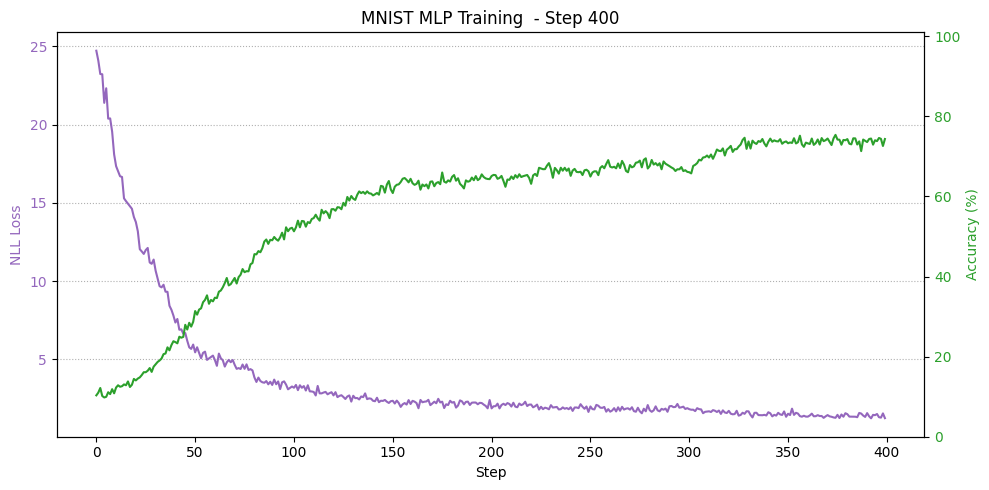

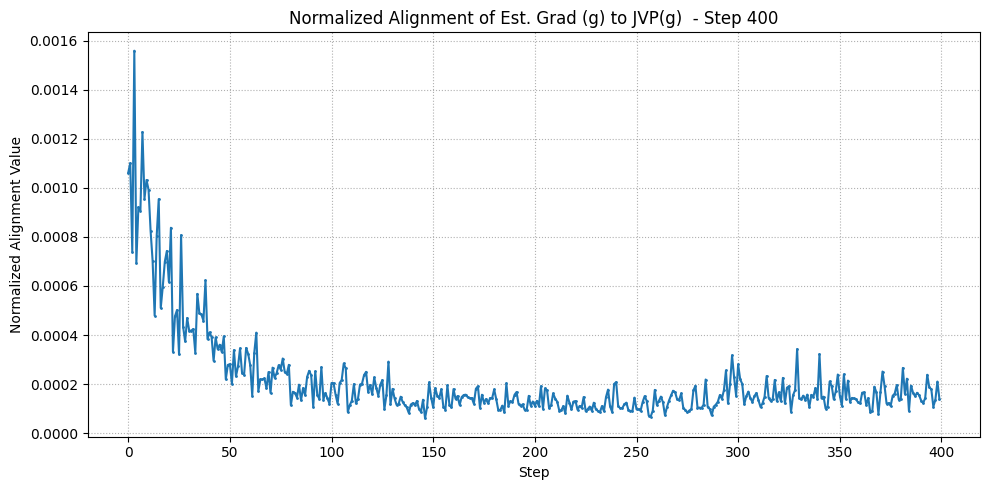

Step [420/2000], WinAvgLoss: 1.3765, CurLoss: 1.1914, Acc: 76.89%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [440/2000], WinAvgLoss: 1.2981, CurLoss: 1.2796, Acc: 76.23%, Align: 0.0001, NoiseDens: 4.78e-05, Samples: 64
Step [460/2000], WinAvgLoss: 1.2005, CurLoss: 1.1728, Acc: 77.17%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [480/2000], WinAvgLoss: 1.1604, CurLoss: 1.1705, Acc: 77.09%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [500/2000], WinAvgLoss: 1.1251, CurLoss: 1.1129, Acc: 77.11%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [520/2000], WinAvgLoss: 1.1222, CurLoss: 1.2516, Acc: 78.09%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [540/2000], WinAvgLoss: 1.0609, CurLoss: 0.9906, Acc: 78.73%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64

-- Adaptation Triggered at end of Step 560 --
   Avg Loss increased (1.0609 -> 1.0954)
   Noise density halved to: 2.39e-05
   Sample size doubled to: 128
Step [560/2000], WinAvgLoss: 1.0954, Cu

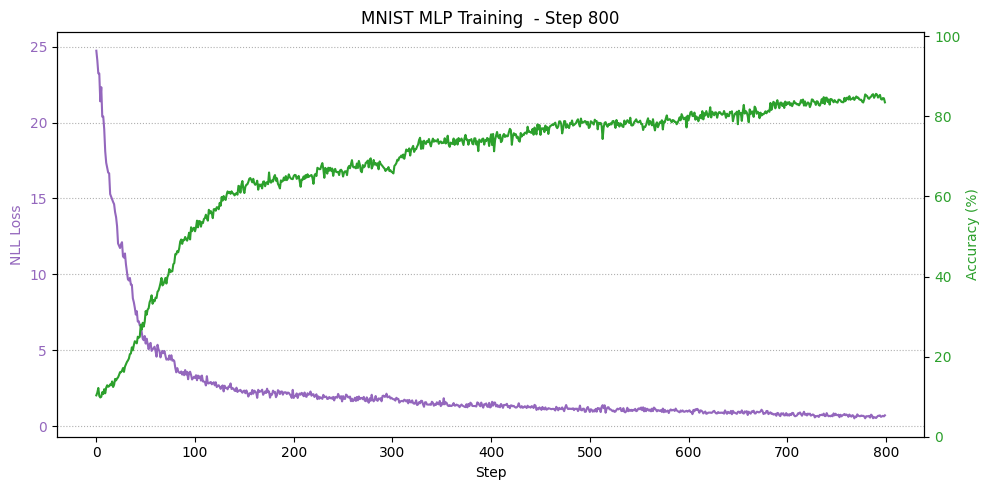

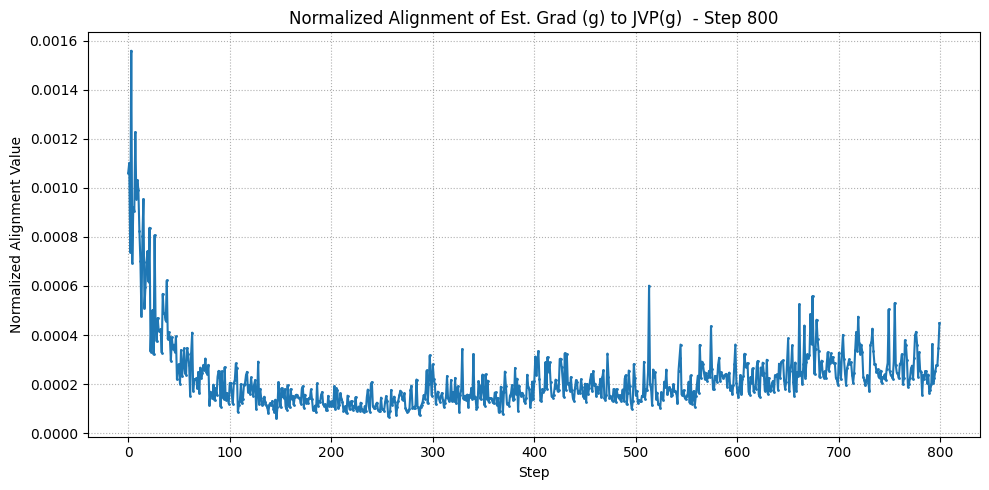

Step [820/2000], WinAvgLoss: 0.6142, CurLoss: 0.6080, Acc: 85.74%, Align: 0.0002, NoiseDens: 2.99e-06, Samples: 256
Step [840/2000], WinAvgLoss: 0.5909, CurLoss: 0.5888, Acc: 86.82%, Align: 0.0002, NoiseDens: 2.99e-06, Samples: 256
Step [860/2000], WinAvgLoss: 0.5737, CurLoss: 0.5342, Acc: 86.43%, Align: 0.0002, NoiseDens: 2.99e-06, Samples: 256
Step [880/2000], WinAvgLoss: 0.5375, CurLoss: 0.5238, Acc: 86.02%, Align: 0.0002, NoiseDens: 2.99e-06, Samples: 256

-- Adaptation Triggered at end of Step 900 --
   Avg Loss increased (0.5375 -> 0.5738)
   Noise density halved to: 1.49e-06
Step [900/2000], WinAvgLoss: 0.5738, CurLoss: 0.6037, Acc: 86.11%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [920/2000], WinAvgLoss: 0.5298, CurLoss: 0.4760, Acc: 87.30%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [940/2000], WinAvgLoss: 0.5099, CurLoss: 0.5091, Acc: 88.14%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [960/2000], WinAvgLoss: 0.5209, CurLoss: 0.4973, Acc: 87.7

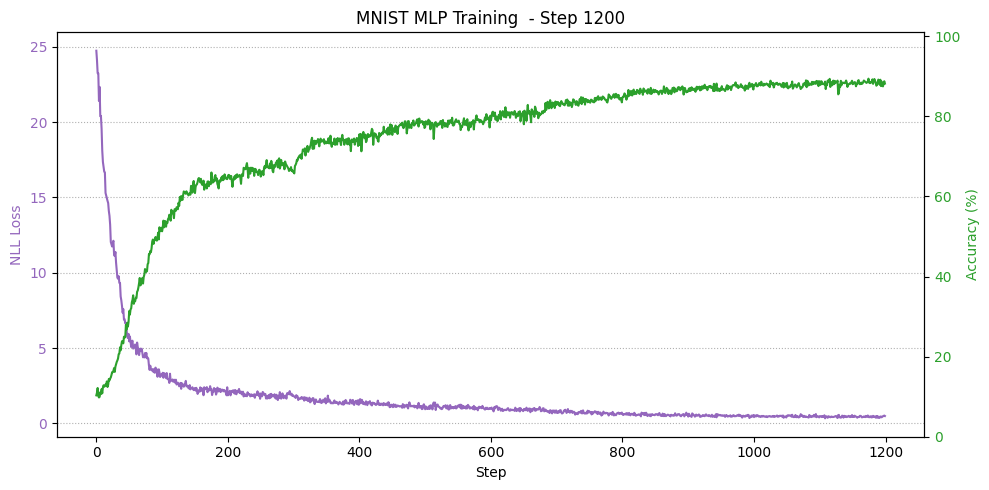

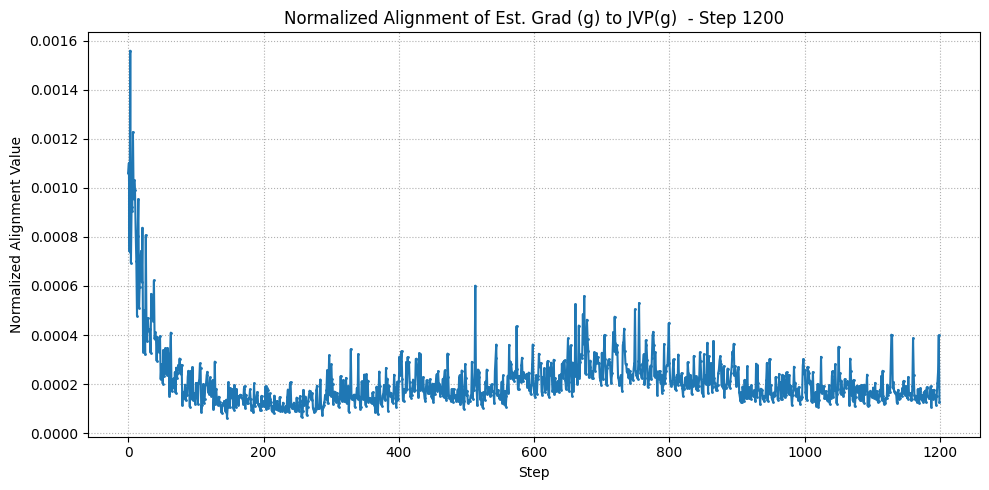

Step [1220/2000], WinAvgLoss: 0.4297, CurLoss: 0.4696, Acc: 89.12%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1240/2000], WinAvgLoss: 0.4254, CurLoss: 0.4001, Acc: 89.67%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1260/2000], WinAvgLoss: 0.4461, CurLoss: 0.4297, Acc: 88.38%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1280/2000], WinAvgLoss: 0.4193, CurLoss: 0.3633, Acc: 88.50%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1300/2000], WinAvgLoss: 0.4274, CurLoss: 0.4363, Acc: 88.52%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1320/2000], WinAvgLoss: 0.4205, CurLoss: 0.4109, Acc: 88.67%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1340/2000], WinAvgLoss: 0.4267, CurLoss: 0.4218, Acc: 88.46%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1360/2000], WinAvgLoss: 0.4225, CurLoss: 0.4760, Acc: 89.10%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1380/2000], WinAvgLoss: 0.4357, CurLoss: 0.4950, Acc: 88.7

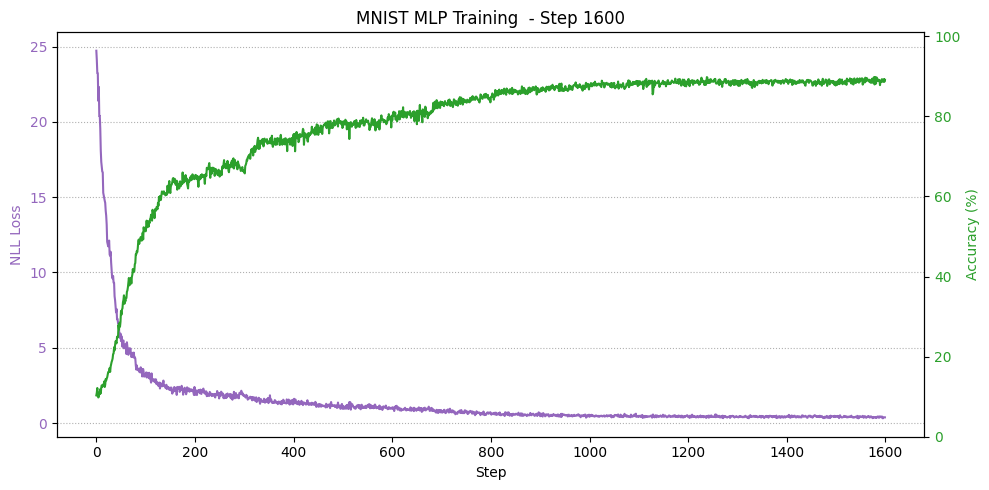

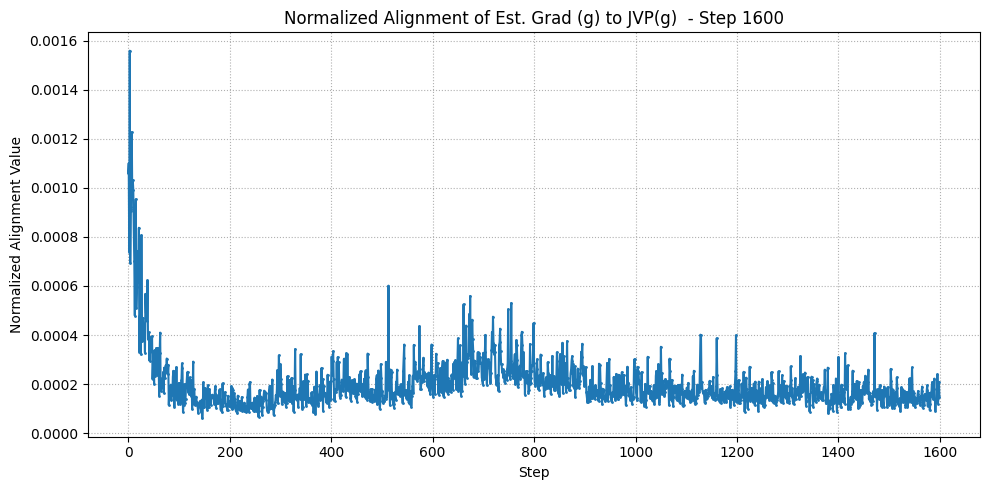

Step [1620/2000], WinAvgLoss: 0.3955, CurLoss: 0.4122, Acc: 88.91%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1640/2000], WinAvgLoss: 0.3959, CurLoss: 0.3677, Acc: 88.63%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1660/2000], WinAvgLoss: 0.3768, CurLoss: 0.3965, Acc: 89.04%, Align: 0.0003, NoiseDens: 1.49e-06, Samples: 256
Step [1680/2000], WinAvgLoss: 0.4013, CurLoss: 0.4211, Acc: 88.69%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1700/2000], WinAvgLoss: 0.3855, CurLoss: 0.4073, Acc: 88.61%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1720/2000], WinAvgLoss: 0.3993, CurLoss: 0.4168, Acc: 88.81%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 256
Step [1740/2000], WinAvgLoss: 0.3905, CurLoss: 0.3242, Acc: 88.83%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1760/2000], WinAvgLoss: 0.3850, CurLoss: 0.3851, Acc: 88.95%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 256
Step [1780/2000], WinAvgLoss: 0.4011, CurLoss: 0.4336, Acc: 88.6

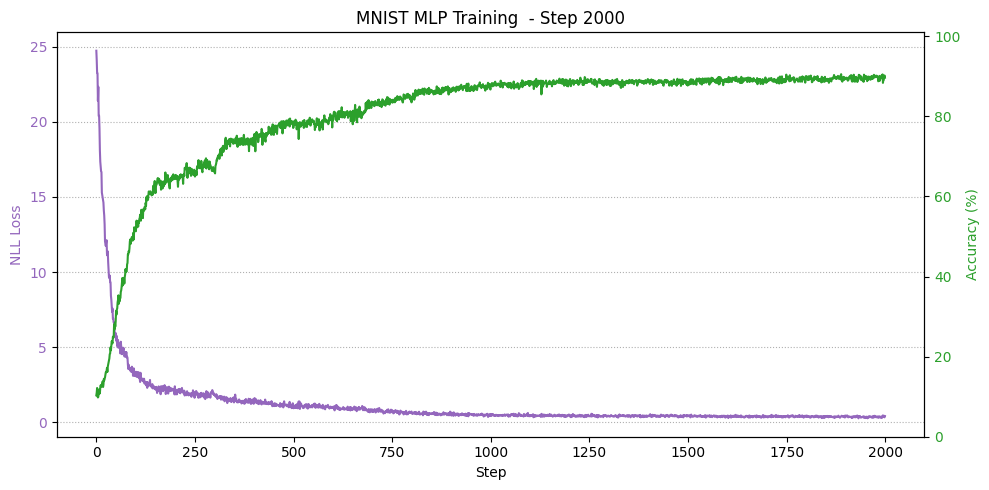

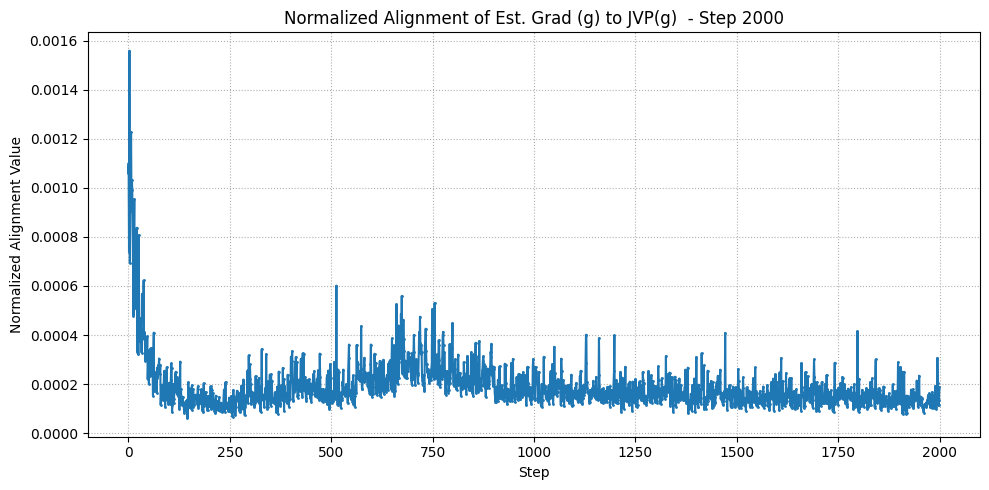


Training finished.


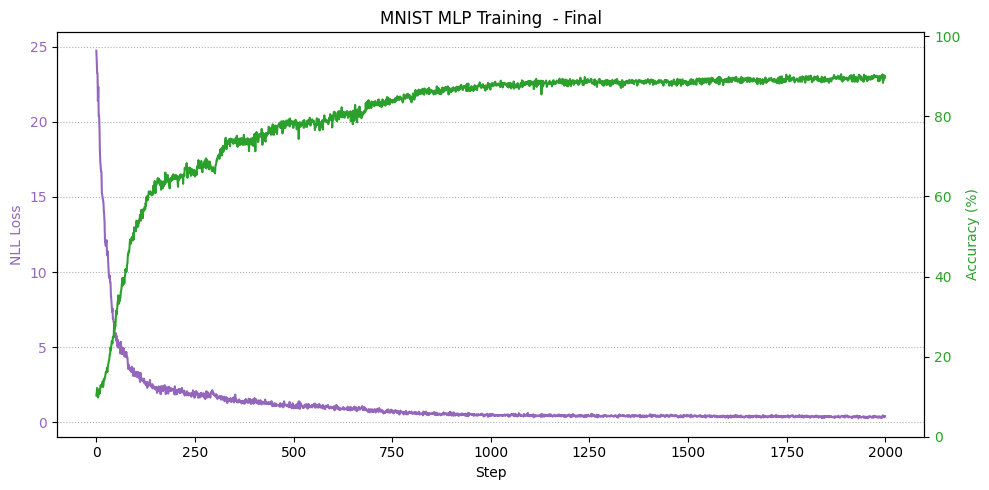

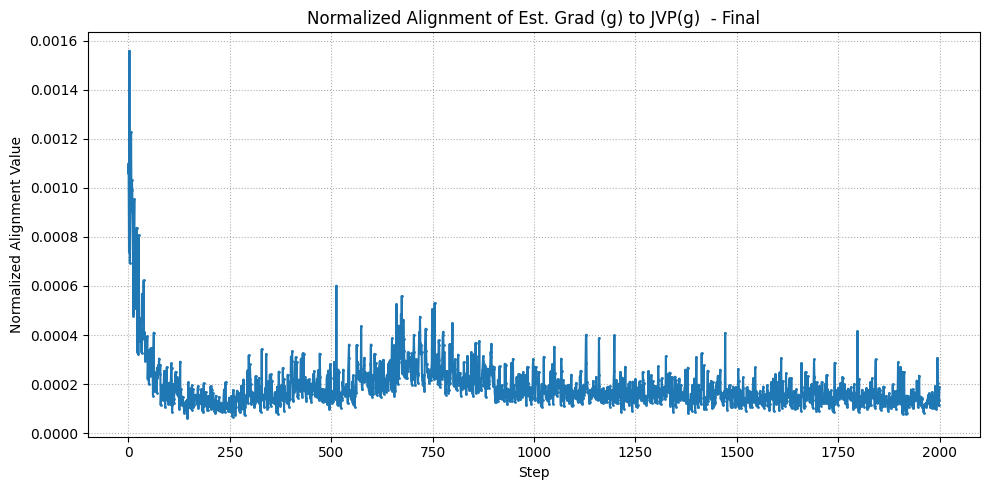

In [ ]:
# -*- coding: utf-8 -*-
"""
lk99_proof_windowed_avg_loss_fixed.py

Complete script demonstrating the algorithm with:
1. Batched JVP computation using torch.func.vmap.
2. Windowed average loss adaptation:
    - Every 20 steps, compare the average loss of the last window
      to the previous window's average.
    - If average loss increases:
        - Halve noise density (respecting minimum).
        - Double sample size (respecting maximum).
3. Higher initial noise density and low initial samples.
4. *** Includes the previously missing 'probs' function definition. ***
5. All necessary helper functions included for standalone execution.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Helper Functions (Quantization, Noise Generation) ---
def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  level_tensor = tch.tensor(level, device=dev) if not isinstance(level, tch.Tensor) else level.to(dev)
  return tch.where(signal < level_tensor, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    tch.manual_seed(seed)
    if device == tch.device("cuda"): tch.cuda.manual_seed_all(seed)
  # Generates values in [-1, 1], then quantizes based on w thresholds
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

def rand_mask(shape, p, device=None):
  random_tensor = tch.rand(shape, device=device)
  p_val = min(max(p, 0.0), 1.0)
  return lt(random_tensor, p_val, device=device)

def randu():
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

# >>>>>>>>>>>> ADDED MISSING FUNCTION <<<<<<<<<<<<<<<<<<
# given a mean value, generate random probabilities for symbols [a = -1, b = 0, c = 1]
# such that the expected value is the mean. Sparsity controls probability of 0.
def probs(mean, sparsity = None):
  # Ensure mean is within valid range [-1, 1]
  mean = max(-1.0, min(1.0, mean))

  # Calculate bounds for p_z (probability of 0)
  z_min = max(0.0, abs(mean) - 1.0) # Should always be 0 for ternary
  z_max = min(1.0, 1.0 - abs(mean))

  # Determine p_z: use sparsity if provided, else random within bounds
  if sparsity is not None:
      p_z = min(max(float(sparsity), z_min), z_max)
  else:
      p_z = rand_between(z_min, z_max).item() # Random sparsity

  # Given p_z and mean, solve for p_n (prob of -1) and p_u (prob of +1)
  # mean = (-1 * p_n) + (0 * p_z) + (1 * p_u) = p_u - p_n
  # 1 = p_n + p_z + p_u
  # From sum: p_u + p_n = 1 - p_z
  # Add equations: mean + (1 - p_z) = 2 * p_u => p_u = (1 - p_z + mean) / 2
  # Subtract equations: (1 - p_z) - mean = 2 * p_n => p_n = (1 - p_z - mean) / 2

  p_u = (1.0 - p_z + mean) / 2.0
  p_n = (1.0 - p_z - mean) / 2.0

  # Clamp probabilities to [0, 1] due to potential float inaccuracies
  p_n = min(max(p_n, 0.0), 1.0)
  p_z = min(max(p_z, 0.0), 1.0)
  p_u = min(max(p_u, 0.0), 1.0)

  # Re-normalize if necessary (should be close to 1)
  total_p = p_n + p_z + p_u
  if not math.isclose(total_p, 1.0):
      if total_p > 1e-9:
          p_n /= total_p
          p_z /= total_p
          p_u /= total_p
      else: # Failsafe: uniform distribution if total is zero
          p_n, p_z, p_u = 1/3, 1/3, 1/3

  # Return distribution for [-1, 0, +1]
  return [p_n, p_z, p_u]
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

def sign_noise(shape, mean = 0.0, device=None):
  # For mean=0 and sparsity=0, probs() should return [0.5, 0, 0.5]
  # rand_tern with these probs generates {-1, +1} noise.
  w_dist = probs(mean, sparsity=0)
  return rand_tern(shape, w=w_dist, device=device)

# --- Data Loading ---
def get_batch(batch_size, device):
  transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()])
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0
  try: mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  except Exception as e: print(f"Error loading MNIST dataset: {e}"); raise
  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size <= 0: raise ValueError(f"Batch size must be positive, got {batch_size}")
  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)
  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except RuntimeError as e:
      print(f"DataLoader error (num_workers={num_workers}), retrying with 0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))
  except Exception as e: print(f"Unexpected batch loading error: {e}"); raise
  data, target = batch
  data = data.to(device, non_blocking=pin_memory); target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test batch loading
try: _ = get_batch(1, device); print("Batch loading test successful.")
except Exception as e: print(f"ERROR: Failed initial batch loading test: {e}"); exit()

# --- Network Definition ---
def layer_norm(x, eps=1e-5):
  mean = tch.mean(x, dim=-1, keepdim=True); var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps)

def total_params(input_size, hidden_size, output_size):
  ti = 0; ti += input_size * hidden_size + hidden_size # Layer 1
  ti += hidden_size * hidden_size + hidden_size       # Layer 2
  ti += hidden_size * output_size + output_size       # Layer 3
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  ti = 0
  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size); ti += input_size * hidden_size
  b1 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size); ti += hidden_size * hidden_size
  b2 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size); ti += hidden_size * output_size
  b3 = t_params[ti:ti + output_size].view(output_size); ti += output_size
  x = x.view(-1, input_size)
  x = F.relu(layer_norm(x @ w1.t() + b1)) # Layer 1
  x = F.relu(layer_norm(x @ w2.t() + b2)) # Layer 2
  output = F.log_softmax(x @ w3.t() + b3, dim=1) # Output
  return output

# --- Loss and Accuracy Functions ---
def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch; output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  return F.nll_loss(output, target.long())

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item(); total = target.size(0)
  return 100.0 * correct / total

# --- Plotting Function ---
def plot(loss_record, acc_record, align_record, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 5)); title = f"MNIST MLP Training {title_suffix}"; plt.title(title)
    color = 'tab:purple'; ax1.set_xlabel('Step'); ax1.set_ylabel('NLL Loss', color=color)
    steps_loss = [i for i, x in enumerate(loss_record) if np.isfinite(x)]
    loss_vals = [x for x in loss_record if np.isfinite(x)]
    ax1.plot(steps_loss, loss_vals, color=color, linestyle='-', label='Loss'); ax1.tick_params(axis='y', labelcolor=color); ax1.grid(True, axis='y', linestyle=':')
    ax2 = ax1.twinx(); color = 'tab:green'; ax2.set_ylabel('Accuracy (%)', color=color)
    steps_acc = [i for i, x in enumerate(acc_record) if np.isfinite(x)]
    acc_vals = [x for x in acc_record if np.isfinite(x)]
    ax2.plot(steps_acc, acc_vals, color=color, linestyle='-', label='Accuracy'); ax2.tick_params(axis='y', labelcolor=color); ax2.set_ylim(0, 101)
    fig.tight_layout(); plt.show()
    plt.figure(figsize=(10, 5)); plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step"); plt.ylabel("Normalized Alignment Value")
    steps_align = [i for i, x in enumerate(align_record) if np.isfinite(x)]
    align_vals = [x for x in align_record if np.isfinite(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2); plt.grid(True, linestyle=':'); plt.tight_layout(); plt.show()

# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512
output_size = 10
eval_batch_size_factor = 5
eval_batch_max = 10000

# Determine total parameters
dim = total_params(input_size, hidden_size, output_size)

# --- Adaptive Parameters ---
initial_noise_density_factor = 8.0 # Start with high density
initial_samples = 16             # Start with 16 samples
max_samples = initial_samples * 16 # Max samples (e.g., 16 * 16 = 256)
min_abs_noise_density = 1 / dim    # Absolute minimum density
adaptation_window_size = 20      # Check average loss every 20 steps

# Initialize theta
theta = rand_tern((dim,), device=device, requires_grad=False)

# Initialize adaptive variables
base_density = 16 / dim
initial_noise_density = min(1.0, base_density * initial_noise_density_factor) # Clamp initial density <= 1.0
noise_density = initial_noise_density
current_samples = initial_samples

# Records and state for adaptation
loss_record = []
acc_record = []
align_record = []
current_window_losses = []       # Store losses for the current window
previous_window_avg_loss = float('inf') # Store the average loss of the previous window

print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Initial samples: {initial_samples}, Max samples: {max_samples}")
print(f"Initial noise density: {initial_noise_density:.3e} (Factor: {initial_noise_density_factor}x Base)")
print(f"Min Absolute Noise Density: {min_abs_noise_density:.2e}")
print(f"Adaptation Rule: Every {adaptation_window_size} steps, if avg loss increased -> Halve Density, Double Samples")
print(f"----------------------------")

# Main training loop
for j in tqdm(range(steps), desc="Training Progress"):
    # 1. Get Training Batch
    try: batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nERROR getting training batch at step {j}: {e}. Skipping.")
        loss_record.append(float('nan')); acc_record.append(float('nan')); align_record.append(float('nan'))
        current_window_losses.append(float('nan')) # Record NaN for this step's loss
        continue

    # 2. Define Loss Closure
    theta.requires_grad_(False)
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # 3. Batched JVP
    current_loss = float('nan'); g = tch.zeros_like(theta) # Defaults
    try:
        masks = rand_mask((current_samples, dim), noise_density, device=device)
        # Use sign_noise which now correctly uses the defined probs function
        s_noises = sign_noise((current_samples, dim), mean=0.0, device=device)
        perturbs_batch = s_noises * masks

        def single_jvp(tangent_vector):
            l, jvp_val = tch.func.jvp(f, (theta,), (tangent_vector,))
            return l, jvp_val

        theta.requires_grad_(False); perturbs_batch.requires_grad_(True)
        all_losses, aligns_batch = tch.func.vmap(single_jvp)(perturbs_batch)
        perturbs_batch.requires_grad_(False)

        valid_indices = tch.isfinite(aligns_batch) & tch.isfinite(all_losses)
        num_valid = valid_indices.sum().item()

        if num_valid == 0: print(f"\nWarning: All {current_samples} JVP invalid at step {j}.")
        else:
            if num_valid < current_samples: print(f"\nWarning: {current_samples - num_valid}/{current_samples} JVP invalid at step {j}.")
            valid_aligns = aligns_batch[valid_indices]; valid_perturbs = perturbs_batch[valid_indices]
            current_loss_tensor = all_losses[valid_indices].mean()
            current_loss = current_loss_tensor.item() # Get the current loss value

            # 4. Gradient Estimation
            if valid_aligns.numel() > 0:
                median = tch.median(valid_aligns.abs())
                safe_median = max(median.item(), 1e-9) * tch.ones_like(median)
                align_terns = valid_aligns.sign() * tch.where(valid_aligns.abs() >= safe_median, 1.0, 0.0).float() # Ensure float
                g_nontern = tch.sum(valid_perturbs * align_terns[:,None], dim=0)
                g = quant(g_nontern)
            elif np.isfinite(current_loss): print(f"Step {j}: No valid alignments. Using zero gradient.")

    except NameError as e:
        print(f"\nFATAL ERROR during JVP/Grad Est at step {j}: {e}")
        print("This likely means a helper function (like 'probs') is still missing or misspelled.")
        break # Stop execution if a core function is missing
    except Exception as e:
        print(f"\nERROR during JVP/Grad Est at step {j}: {e}")
        current_loss = float('nan'); acc = float('nan'); true_algn = float('nan')
        loss_record.append(current_loss); acc_record.append(acc); align_record.append(true_algn)
        current_window_losses.append(current_loss) # Record NaN loss in window
        if 'perturbs_batch' in locals() and perturbs_batch.requires_grad: perturbs_batch.requires_grad_(False)
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
        continue

    # 5. Accuracy Calculation
    acc = float('nan')
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000)
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size)
    except Exception as e: print(f"\nWarning: Error during accuracy calculation at step {j}: {e}")

    # 6. Alignment Check
    true_algn = float('nan')
    if tch.count_nonzero(g) > 0:
        try:
            g.requires_grad_(True); theta.requires_grad_(False)
            _, true_algn_tensor = tch.func.jvp(f,(theta,),(g,))
            g.requires_grad_(False)
            norm_factor = tch.linalg.norm(g, ord=1).item()
            if norm_factor < 1e-9: norm_factor = max(dim * noise_density, 1e-6)
            true_algn = true_algn_tensor.item() / norm_factor
            if not np.isfinite(true_algn): true_algn = float('nan')
        except Exception as e: print(f"\nWarning: Error during alignment JVP at step {j}: {e}")
        if 'g' in locals() and g.requires_grad: g.requires_grad_(False)
    else: true_algn = 0.0

    # 7. Parameter Update
    with tch.no_grad(): theta = quant(theta - g)

    # 8. Record Metrics & Add Loss to Current Window
    loss_to_record = current_loss if np.isfinite(current_loss) else float('nan')
    loss_record.append(loss_to_record)
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))
    current_window_losses.append(loss_to_record) # Add loss (or NaN) to window list


    # --- 9. Adaptation Check at Window End ---
    run_adaptation_check = (j + 1) % adaptation_window_size == 0 and j >= adaptation_window_size - 1 # Ensure window is full

    density_changed = False
    samples_changed = False

    if run_adaptation_check:
        valid_window_losses = [l for l in current_window_losses if np.isfinite(l)]
        current_avg_loss = np.mean(valid_window_losses) if len(valid_window_losses) > 0 else float('nan')

        if np.isfinite(current_avg_loss) and np.isfinite(previous_window_avg_loss):
            # Add a small tolerance to prevent reacting to tiny fluctuations
            if current_avg_loss > previous_window_avg_loss + 1e-5:
                old_noise_density = noise_density; old_samples = current_samples
                noise_density /= 2.0; noise_density = max(noise_density, min_abs_noise_density)
                current_samples *= 2; current_samples = min(current_samples, max_samples); current_samples = int(current_samples)
                if noise_density < old_noise_density: density_changed = True
                if current_samples > old_samples: samples_changed = True

                if density_changed or samples_changed:
                     print(f"\n-- Adaptation Triggered at end of Step {j+1} --")
                     print(f"   Avg Loss increased ({previous_window_avg_loss:.4f} -> {current_avg_loss:.4f})")
                     if density_changed: print(f"   Noise density halved to: {noise_density:.2e}")
                     if samples_changed: print(f"   Sample size doubled to: {current_samples}")

        previous_window_avg_loss = current_avg_loss
        current_window_losses = [] # Clear for next window
    # ------------------------------------------

    # 10. Print Progress (Every 20 steps)
    if (j + 1) % adaptation_window_size == 0 or j == steps - 1:
        # Calculate average loss of the *just finished* window for reporting
        # Use the full loss_record to get the correct window slice
        start_index = max(0, j + 1 - adaptation_window_size)
        report_window_losses = loss_record[start_index : j + 1]
        valid_report_losses = [l for l in report_window_losses if np.isfinite(l)]
        report_avg_loss = np.mean(valid_report_losses) if len(valid_report_losses) > 0 else float('nan')
        avg_loss_str = f"{report_avg_loss:.4f}" if np.isfinite(report_avg_loss) else "NaN"

        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"

        print(f"Step [{j+1}/{steps}], WinAvgLoss: {avg_loss_str}, CurLoss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}, Samples: {current_samples}")

    # 11. Plot Periodically (e.g., every 400 steps)
    if (j + 1) % 400 == 0 and j > 0:
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---

CUDA available. Using GPU: Tesla T4


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.71MB/s]


Batch loading test successful.
--- Training Configuration ---
Problem dim: 669706
Target device: cuda
Train Batch size: 1024
Eval Batch size: ~5120
Initial samples: 16, Max samples: 1024
Sample Chunk Size (Memory Opt): 64
Initial noise density: 1.911e-04 (Factor: 8.0x Base)
Min Absolute Noise Density: 1.49e-06
Adaptation Rule: Every 20 steps, if avg loss increased -> Halve Density, Double Samples
----------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

DataLoader error (num_workers=2), retrying with 0. Error: DataLoader worker (pid(s) 1684) exited unexpectedly
Step [20/2000], WinAvgLoss: 16.0121, CurLoss: 11.7041, Acc: 15.23%, Align: 0.0004, NoiseDens: 1.91e-04, Samples: 16
Step [40/2000], WinAvgLoss: 8.8176, CurLoss: 6.8476, Acc: 23.24%, Align: 0.0003, NoiseDens: 1.91e-04, Samples: 16
Step [60/2000], WinAvgLoss: 5.7836, CurLoss: 5.2497, Acc: 33.14%, Align: 0.0002, NoiseDens: 1.91e-04, Samples: 16
Step [80/2000], WinAvgLoss: 4.6644, CurLoss: 4.1625, Acc: 43.48%, Align: 0.0002, NoiseDens: 1.91e-04, Samples: 16
Step [100/2000], WinAvgLoss: 3.7008, CurLoss: 3.4086, Acc: 46.80%, Align: 0.0002, NoiseDens: 1.91e-04, Samples: 16
Step [120/2000], WinAvgLoss: 3.1843, CurLoss: 2.8355, Acc: 55.04%, Align: 0.0001, NoiseDens: 1.91e-04, Samples: 16
Step [140/2000], WinAvgLoss: 2.8063, CurLoss: 2.6361, Acc: 58.69%, Align: 0.0002, NoiseDens: 1.91e-04, Samples: 16
Step [160/2000], WinAvgLoss: 2.4930, CurLoss: 2.3245, Acc: 60.43%, Align: 0.0001, Noise

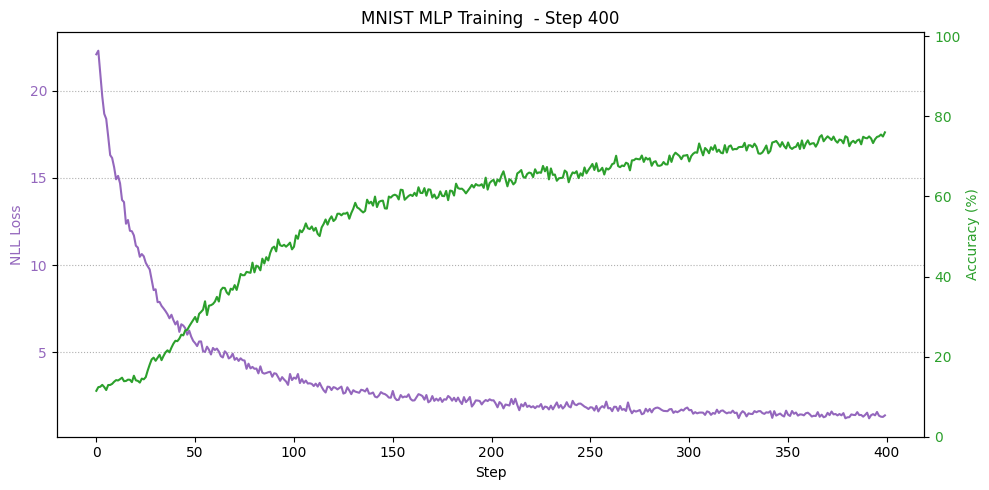

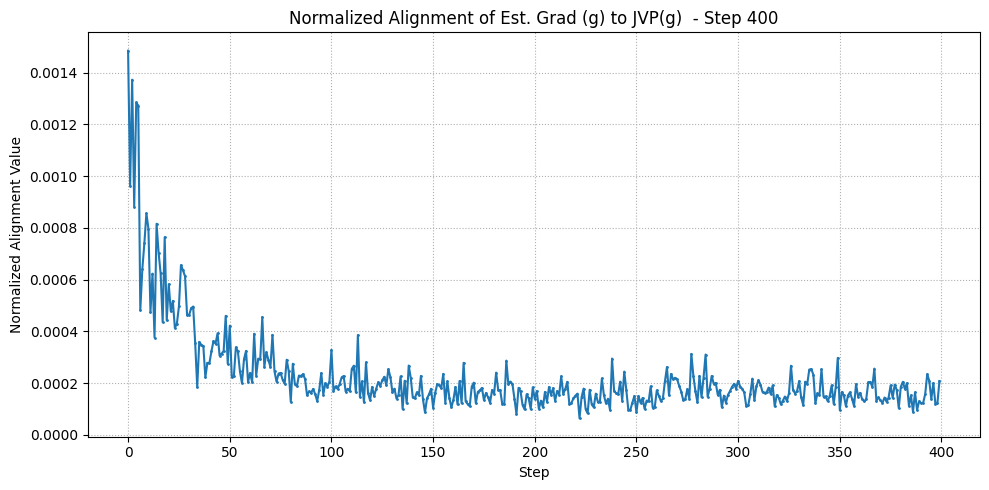

Step [420/2000], WinAvgLoss: 1.3758, CurLoss: 1.4493, Acc: 72.89%, Align: 0.0002, NoiseDens: 9.56e-05, Samples: 32
Step [440/2000], WinAvgLoss: 1.2928, CurLoss: 1.3601, Acc: 75.35%, Align: 0.0001, NoiseDens: 9.56e-05, Samples: 32

-- Adaptation Triggered at end of Step 460 --
   Avg Loss increased (1.2928 -> 1.3382)
   Noise density halved to: 4.78e-05
   Sample size doubled to: 64
Step [460/2000], WinAvgLoss: 1.3382, CurLoss: 1.4372, Acc: 74.98%, Align: 0.0001, NoiseDens: 4.78e-05, Samples: 64
Step [480/2000], WinAvgLoss: 1.2912, CurLoss: 1.1877, Acc: 76.09%, Align: 0.0001, NoiseDens: 4.78e-05, Samples: 64
Step [500/2000], WinAvgLoss: 1.1829, CurLoss: 1.0797, Acc: 78.01%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [520/2000], WinAvgLoss: 1.1471, CurLoss: 1.2102, Acc: 79.12%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64
Step [540/2000], WinAvgLoss: 1.1037, CurLoss: 1.1275, Acc: 78.32%, Align: 0.0002, NoiseDens: 4.78e-05, Samples: 64

-- Adaptation Triggered at end of Step 

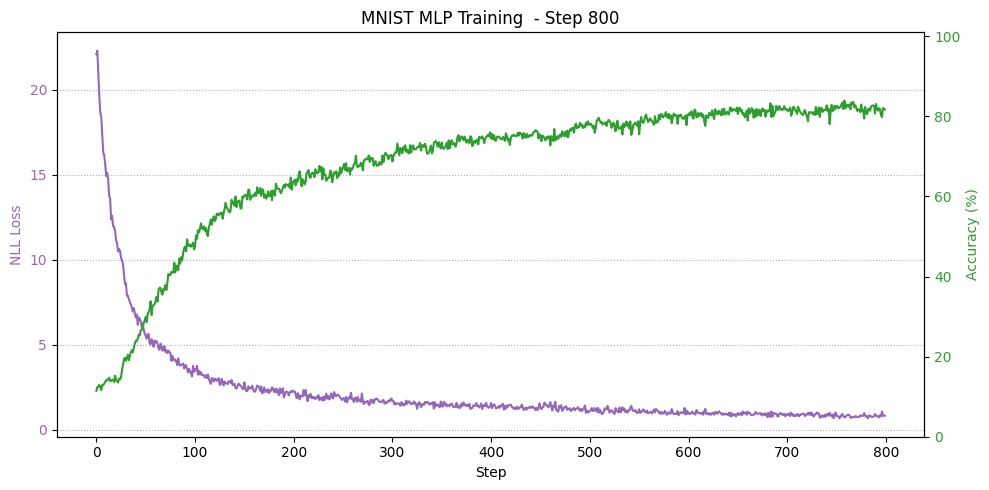

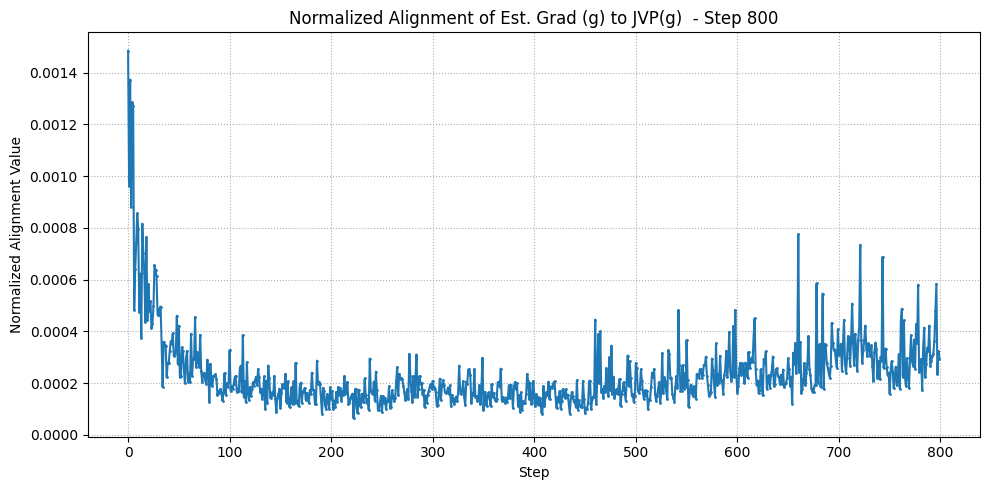


-- Adaptation Triggered at end of Step 820 --
   Avg Loss increased (0.8071 -> 0.8521)
   Noise density halved to: 2.99e-06
   Sample size doubled to: 1024
Step [820/2000], WinAvgLoss: 0.8521, CurLoss: 0.7633, Acc: 81.70%, Align: 0.0004, NoiseDens: 2.99e-06, Samples: 1024
Step [840/2000], WinAvgLoss: 0.8031, CurLoss: 1.0417, Acc: 81.15%, Align: 0.0008, NoiseDens: 2.99e-06, Samples: 1024
Step [860/2000], WinAvgLoss: 0.7582, CurLoss: 0.8488, Acc: 83.75%, Align: 0.0005, NoiseDens: 2.99e-06, Samples: 1024
Step [880/2000], WinAvgLoss: 0.7472, CurLoss: 0.6061, Acc: 84.51%, Align: 0.0003, NoiseDens: 2.99e-06, Samples: 1024
Step [900/2000], WinAvgLoss: 0.7119, CurLoss: 0.6486, Acc: 82.60%, Align: 0.0004, NoiseDens: 2.99e-06, Samples: 1024

-- Adaptation Triggered at end of Step 920 --
   Avg Loss increased (0.7119 -> 0.7239)
   Noise density halved to: 1.49e-06
Step [920/2000], WinAvgLoss: 0.7239, CurLoss: 0.7091, Acc: 83.20%, Align: 0.0007, NoiseDens: 1.49e-06, Samples: 1024
Step [940/2000],

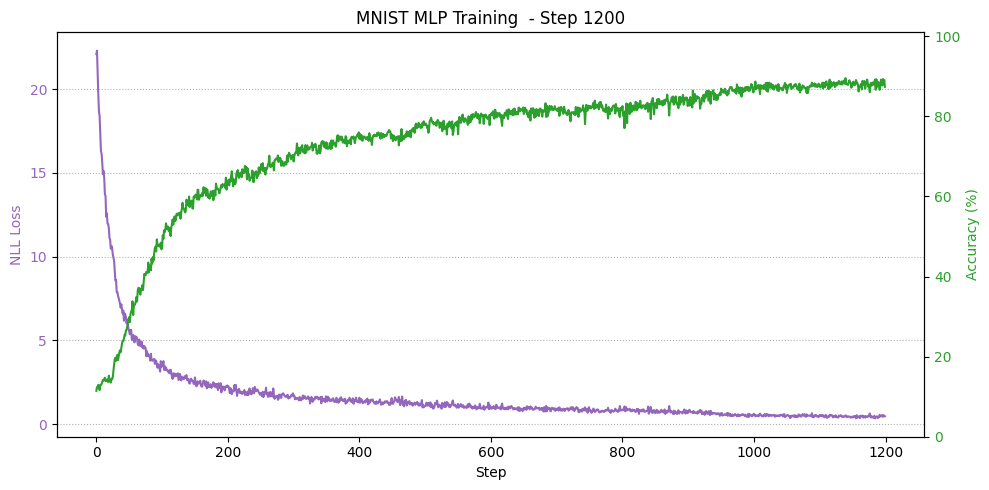

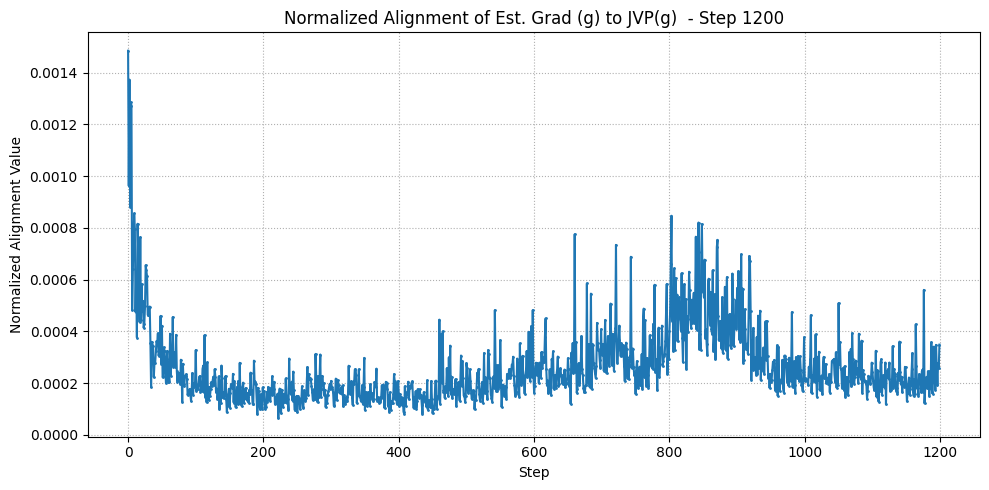

Step [1220/2000], WinAvgLoss: 0.4518, CurLoss: 0.4335, Acc: 88.87%, Align: 0.0001, NoiseDens: 1.49e-06, Samples: 1024
Step [1240/2000], WinAvgLoss: 0.4535, CurLoss: 0.4138, Acc: 89.67%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 1024
Step [1260/2000], WinAvgLoss: 0.4272, CurLoss: 0.5365, Acc: 88.18%, Align: 0.0003, NoiseDens: 1.49e-06, Samples: 1024
Step [1280/2000], WinAvgLoss: 0.4194, CurLoss: 0.5085, Acc: 88.98%, Align: 0.0002, NoiseDens: 1.49e-06, Samples: 1024


In [1]:
# -*- coding: utf-8 -*-
"""
lk99_proof_windowed_avg_loss_fixed_memopt.py

Complete script demonstrating the algorithm with:
1. Batched JVP computation using torch.func.vmap.
2. *** Memory optimization: Chunked processing of samples for JVP/gradient estimation. ***
3. Windowed average loss adaptation:
    - Every 20 steps, compare the average loss of the last window
      to the previous window's average.
    - If average loss increases:
        - Halve noise density (respecting minimum).
        - Double sample size (respecting maximum).
4. Higher initial noise density and low initial samples.
5. Includes the previously missing 'probs' function definition.
6. All necessary helper functions included for standalone execution.
"""

import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import gc # Garbage collector for potential explicit cleanup

# Use tqdm for progress bar if available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found. Install with 'pip install tqdm' for a progress bar.")
    def tqdm(iterable, *args, **kwargs): # Dummy tqdm if not installed
        return iterable

# --- GPU Setup ---
if tch.cuda.is_available():
    device = tch.device("cuda")
    print(f"CUDA available. Using GPU: {tch.cuda.get_device_name(0)}")
else:
    device = tch.device("cpu")
    print("CUDA not available. Using CPU.")
# -----------------

# --- Helper Functions (Quantization, Noise Generation) ---
def quant_internal(nontern, w, device=None):
  dev = device if device is not None else nontern.device
  result = tch.zeros_like(nontern, device=dev)
  result = tch.where(nontern <= -1 + 2 * w[0],         tch.tensor(-1.0, device=dev), result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), tch.tensor( 1.0, device=dev), result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3], device=None):
  dev = device if device is not None else nontern.device
  return quant_internal(nontern, w, device=dev)

def lt(signal, level, device=None):
  dev = device if device is not None else signal.device
  level_tensor = tch.tensor(level, device=dev) if not isinstance(level, tch.Tensor) else level.to(dev)
  return tch.where(signal < level_tensor, tch.tensor(1.0, device=dev), tch.zeros_like(signal, device=dev))

def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False, device=None):
  if seed is not None:
    tch.manual_seed(seed)
    if device == tch.device("cuda"): tch.cuda.manual_seed_all(seed)
  # Generates values in [-1, 1], then quantizes based on w thresholds
  random_tensor = (2 * tch.rand(shape, requires_grad=requires_grad, device=device)) - 1
  return quant(random_tensor, w, device=device)

def rand_mask(shape, p, device=None):
  random_tensor = tch.rand(shape, device=device)
  p_val = min(max(p, 0.0), 1.0)
  return lt(random_tensor, p_val, device=device)

def randu():
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

# given a mean value, generate random probabilities for symbols [a = -1, b = 0, c = 1]
# such that the expected value is the mean. Sparsity controls probability of 0.
def probs(mean, sparsity = None):
  # Ensure mean is within valid range [-1, 1]
  mean = max(-1.0, min(1.0, mean))

  # Calculate bounds for p_z (probability of 0)
  z_min = max(0.0, abs(mean) - 1.0) # Should always be 0 for ternary
  z_max = min(1.0, 1.0 - abs(mean))

  # Determine p_z: use sparsity if provided, else random within bounds
  if sparsity is not None:
      p_z = min(max(float(sparsity), z_min), z_max)
  else:
      p_z = rand_between(z_min, z_max).item() # Random sparsity

  # Given p_z and mean, solve for p_n (prob of -1) and p_u (prob of +1)
  p_u = (1.0 - p_z + mean) / 2.0
  p_n = (1.0 - p_z - mean) / 2.0

  # Clamp probabilities to [0, 1] due to potential float inaccuracies
  p_n = min(max(p_n, 0.0), 1.0)
  p_z = min(max(p_z, 0.0), 1.0)
  p_u = min(max(p_u, 0.0), 1.0)

  # Re-normalize if necessary (should be close to 1)
  total_p = p_n + p_z + p_u
  if not math.isclose(total_p, 1.0):
      if total_p > 1e-9:
          p_n /= total_p
          p_z /= total_p
          p_u /= total_p
      else: # Failsafe: uniform distribution if total is zero
          p_n, p_z, p_u = 1/3, 1/3, 1/3

  # Return distribution for [-1, 0, +1]
  return [p_n, p_z, p_u]

def sign_noise(shape, mean = 0.0, device=None):
  # For mean=0 and sparsity=0, probs() should return [0.5, 0, 0.5]
  # rand_tern with these probs generates {-1, +1} noise.
  w_dist = probs(mean, sparsity=0)
  return rand_tern(shape, w=w_dist, device=device)

# --- Data Loading ---
def get_batch(batch_size, device):
  transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()])
  pin_memory = True if device == tch.device('cuda') else False
  num_workers = 2 if pin_memory else 0
  try: mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  except Exception as e: print(f"Error loading MNIST dataset: {e}"); raise
  actual_batch_size = min(batch_size, len(mnist_train))
  if actual_batch_size <= 0: raise ValueError(f"Batch size must be positive, got {batch_size}")
  indices = random.sample(range(len(mnist_train)), actual_batch_size)
  subset = Subset(mnist_train, indices)
  try:
    loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    batch = next(iter(loader))
  except RuntimeError as e:
      print(f"DataLoader error (num_workers={num_workers}), retrying with 0. Error: {e}")
      loader = DataLoader(subset, batch_size=actual_batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
      batch = next(iter(loader))
  except Exception as e: print(f"Unexpected batch loading error: {e}"); raise
  data, target = batch
  data = data.to(device, non_blocking=pin_memory); target = target.to(device, non_blocking=pin_memory)
  return data, target

# Test batch loading
try: _ = get_batch(1, device); print("Batch loading test successful.")
except Exception as e: print(f"ERROR: Failed initial batch loading test: {e}"); exit()

# --- Network Definition ---
def layer_norm(x, eps=1e-5):
  mean = tch.mean(x, dim=-1, keepdim=True); var = x.var(dim=-1, unbiased=False, keepdim=True)
  return (x - mean) / tch.sqrt(var + eps)

def total_params(input_size, hidden_size, output_size):
  ti = 0; ti += input_size * hidden_size + hidden_size # Layer 1
  ti += hidden_size * hidden_size + hidden_size       # Layer 2
  ti += hidden_size * output_size + output_size       # Layer 3
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  ti = 0
  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size); ti += input_size * hidden_size
  b1 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size); ti += hidden_size * hidden_size
  b2 = t_params[ti:ti + hidden_size].view(hidden_size); ti += hidden_size
  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size); ti += hidden_size * output_size
  b3 = t_params[ti:ti + output_size].view(output_size); ti += output_size
  x = x.view(-1, input_size)
  x = F.relu(layer_norm(x @ w1.t() + b1)) # Layer 1
  x = F.relu(layer_norm(x @ w2.t() + b2)) # Layer 2
  output = F.log_softmax(x @ w3.t() + b3, dim=1) # Output
  return output

# --- Loss and Accuracy Functions ---
def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch; output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  return F.nll_loss(output, target.long())

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  with tch.no_grad():
      output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
      predictions = tch.argmax(output, dim=1)
      correct = (predictions == target).sum().item(); total = target.size(0)
  return 100.0 * correct / total

# --- Plotting Function ---
def plot(loss_record, acc_record, align_record, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 5)); title = f"MNIST MLP Training {title_suffix}"; plt.title(title)
    color = 'tab:purple'; ax1.set_xlabel('Step'); ax1.set_ylabel('NLL Loss', color=color)
    steps_loss = [i for i, x in enumerate(loss_record) if np.isfinite(x)]
    loss_vals = [x for x in loss_record if np.isfinite(x)]
    ax1.plot(steps_loss, loss_vals, color=color, linestyle='-', label='Loss'); ax1.tick_params(axis='y', labelcolor=color); ax1.grid(True, axis='y', linestyle=':')
    ax2 = ax1.twinx(); color = 'tab:green'; ax2.set_ylabel('Accuracy (%)', color=color)
    steps_acc = [i for i, x in enumerate(acc_record) if np.isfinite(x)]
    acc_vals = [x for x in acc_record if np.isfinite(x)]
    ax2.plot(steps_acc, acc_vals, color=color, linestyle='-', label='Accuracy'); ax2.tick_params(axis='y', labelcolor=color); ax2.set_ylim(0, 101)
    fig.tight_layout(); plt.show()
    plt.figure(figsize=(10, 5)); plt.title(f"Normalized Alignment of Est. Grad (g) to JVP(g) {title_suffix}")
    plt.xlabel("Step"); plt.ylabel("Normalized Alignment Value")
    steps_align = [i for i, x in enumerate(align_record) if np.isfinite(x)]
    align_vals = [x for x in align_record if np.isfinite(x)]
    plt.plot(steps_align, align_vals, marker='.', linestyle='-', markersize=2); plt.grid(True, linestyle=':'); plt.tight_layout(); plt.show()

# --- Main Training Loop ---

# Configurable Parameters
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 512 # Keep small for example, increase for real task
output_size = 10
eval_batch_size_factor = 5
eval_batch_max = 10000

# Determine total parameters
dim = total_params(input_size, hidden_size, output_size)

# --- Adaptive Parameters ---
initial_noise_density_factor = 8.0 # Start with high density
initial_samples = 16             # Start with 16 samples
max_samples = initial_samples * 16 # Max samples (e.g., 16 * 64 = 1024)
min_abs_noise_density = 1 / dim    # Absolute minimum density
adaptation_window_size = 20      # Check average loss every 20 steps
sample_chunk_size = 64           # <<< NEW: Process samples in chunks for memory

# Initialize theta
theta = rand_tern((dim,), device=device, requires_grad=False)

# Initialize adaptive variables
base_density = 16 / dim
initial_noise_density = min(1.0, base_density * initial_noise_density_factor) # Clamp initial density <= 1.0
noise_density = initial_noise_density
current_samples = initial_samples

# Records and state for adaptation
loss_record = []
acc_record = []
align_record = []
current_window_losses = []       # Store losses for the current window
previous_window_avg_loss = float('inf') # Store the average loss of the previous window

print(f"--- Training Configuration ---")
print(f"Problem dim: {dim}")
print(f"Target device: {device}")
print(f"Train Batch size: {batch_size}")
print(f"Eval Batch size: ~{min(batch_size * eval_batch_size_factor, eval_batch_max)}")
print(f"Initial samples: {initial_samples}, Max samples: {max_samples}")
print(f"Sample Chunk Size (Memory Opt): {sample_chunk_size}") # <<< Log chunk size
print(f"Initial noise density: {initial_noise_density:.3e} (Factor: {initial_noise_density_factor}x Base)")
print(f"Min Absolute Noise Density: {min_abs_noise_density:.2e}")
print(f"Adaptation Rule: Every {adaptation_window_size} steps, if avg loss increased -> Halve Density, Double Samples")
print(f"----------------------------")

# Main training loop
for j in tqdm(range(steps), desc="Training Progress"):
    # 1. Get Training Batch
    try: batch = get_batch(batch_size, device)
    except Exception as e:
        print(f"\nERROR getting training batch at step {j}: {e}. Skipping.")
        loss_record.append(float('nan')); acc_record.append(float('nan')); align_record.append(float('nan'))
        current_window_losses.append(float('nan')) # Record NaN for this step's loss
        continue

    # 2. Define Loss Closure
    theta.requires_grad_(False) # Ensure theta is not requiring gradients before JVP
    # Ensure loss_fn captures the current batch correctly. Lambda does this.
    f = lambda t_point: loss_fn(t_point, batch, input_size, hidden_size, output_size)

    # 3. Batched JVP and Gradient Estimation (Chunked for Memory)
    current_loss = float('nan'); g = tch.zeros_like(theta) # Default gradient is zero
    g_nontern = tch.zeros_like(theta) # Accumulator for non-quantized gradient estimate
    all_losses_list = []              # To collect valid losses from chunks
    total_valid_samples = 0           # Count valid samples across chunks

    try:
        # Ensure theta is detached if used inside the JVP function implicitly
        # Having requires_grad_(False) outside might be sufficient for torch.func.jvp
        theta_detached = theta.detach()

        # Define the function for a single JVP, ensuring it uses the detached theta
        def single_jvp(tangent_vector):
            # Use theta_detached to avoid potential requires_grad issues inside vmap
            l, jvp_val = tch.func.jvp(f, (theta_detached,), (tangent_vector,))
            return l, jvp_val

        # --- Loop over sample chunks ---
        for i in range(0, current_samples, sample_chunk_size):
            actual_chunk_size = min(sample_chunk_size, current_samples - i)
            if actual_chunk_size <= 0: continue

            # Generate noise ONLY for the current chunk
            masks_chunk = rand_mask((actual_chunk_size, dim), noise_density, device=device)
            s_noises_chunk = sign_noise((actual_chunk_size, dim), mean=0.0, device=device)
            perturbs_chunk = s_noises_chunk * masks_chunk

            # Compute JVP for the chunk
            # perturbs_chunk does not need requires_grad=True here as it's the tangent input
            losses_chunk, aligns_chunk = tch.func.vmap(single_jvp)(perturbs_chunk)

            # Check validity within the chunk
            valid_indices_chunk = tch.isfinite(aligns_chunk) & tch.isfinite(losses_chunk)
            num_valid_chunk = valid_indices_chunk.sum().item()
            total_valid_samples += num_valid_chunk

            if num_valid_chunk > 0:
                # Process valid results in the chunk
                if num_valid_chunk < actual_chunk_size:
                     tqdm.write(f"\nWarning: {actual_chunk_size - num_valid_chunk}/{actual_chunk_size} JVP invalid in chunk at step {j+1}, offset {i}.")

                valid_losses_chunk = losses_chunk[valid_indices_chunk]
                valid_aligns_chunk = aligns_chunk[valid_indices_chunk]
                valid_perturbs_chunk = perturbs_chunk[valid_indices_chunk] # Need this for grad est

                all_losses_list.append(valid_losses_chunk) # Store valid losses

                # Estimate gradient contribution from this chunk
                if valid_aligns_chunk.numel() > 0:
                    median_chunk = tch.median(valid_aligns_chunk.abs())
                    # Add small epsilon for stability if median is near zero
                    safe_median_chunk = median_chunk + 1e-9
                    align_terns_chunk = valid_aligns_chunk.sign() * tch.where(valid_aligns_chunk.abs() >= safe_median_chunk, 1.0, 0.0).float()

                    # Accumulate gradient estimate contribution
                    g_nontern += tch.sum(valid_perturbs_chunk * align_terns_chunk[:,None], dim=0)

                # Explicitly delete chunk tensors to potentially free memory sooner
                del valid_losses_chunk, valid_aligns_chunk, valid_perturbs_chunk
                if 'align_terns_chunk' in locals(): del align_terns_chunk

            else:
                 tqdm.write(f"\nWarning: All {actual_chunk_size} JVP invalid in chunk at step {j+1}, offset {i}.")

            # Clean up memory for the current chunk's generated noise/results
            del masks_chunk, s_noises_chunk, perturbs_chunk, losses_chunk, aligns_chunk, valid_indices_chunk
            if tch.cuda.is_available():
                tch.cuda.empty_cache() # Be more aggressive if memory is very tight
            gc.collect() # Python garbage collection

        # --- End of chunk loop ---

        # Finalize loss calculation after processing all chunks
        if not all_losses_list:
             if total_valid_samples == 0 and current_samples > 0: # Check if we processed samples but none were valid
                 tqdm.write(f"\nWarning: No valid JVP results across all {current_samples} samples at step {j+1}.")
             current_loss = float('nan')
        else:
             # Concatenate losses from all chunks and calculate the mean
             all_valid_losses = tch.cat(all_losses_list)
             current_loss = all_valid_losses.mean().item()
             del all_valid_losses # Clean up concatenated losses

        # 4. Gradient Finalization (Quantization)
        if total_valid_samples > 0 and tch.count_nonzero(g_nontern) > 0:
            g = quant(g_nontern)
        else:
            # Keep g as zero if no valid samples or accumulator is zero
            g = tch.zeros_like(theta)
            if np.isfinite(current_loss) and current_samples > 0: # Only warn if loss was computed but grad is zero
                 tqdm.write(f"Step {j+1}: Gradient estimate is zero (total valid samples: {total_valid_samples}). Using zero gradient.")

        # Clean up accumulator and list
        del g_nontern, all_losses_list


    except NameError as e:
        print(f"\nFATAL ERROR during JVP/Grad Est at step {j+1}: {e}")
        print("This likely means a helper function (like 'probs') is still missing or misspelled.")
        break # Stop execution
    except Exception as e:
        print(f"\nERROR during JVP/Grad Est at step {j+1}: {e}")
        # Ensure state is clean for the next iteration
        current_loss = float('nan'); acc = float('nan'); true_algn = float('nan'); g = tch.zeros_like(theta)
        loss_record.append(current_loss); acc_record.append(acc); align_record.append(true_algn)
        current_window_losses.append(current_loss) # Record NaN loss in window
        # Clean up any potentially remaining large tensors from the try block
        if 'g_nontern' in locals(): del g_nontern
        if 'all_losses_list' in locals(): del all_losses_list
        if 'all_valid_losses' in locals(): del all_valid_losses
        if tch.cuda.is_available(): tch.cuda.empty_cache()
        gc.collect()
        continue # Skip to next step

    # --- Steps 5-11 remain largely the same ---

    # 5. Accuracy Calculation
    acc = float('nan')
    try:
        eval_batch_size = min(batch_size * eval_batch_size_factor, eval_batch_max, 60000)
        # Use a different batch for evaluation to avoid stale data if get_batch had issues
        eval_batch = get_batch(eval_batch_size, device)
        acc = compute_accuracy(theta, eval_batch, input_size, hidden_size, output_size)
        del eval_batch # Clean up eval batch
    except Exception as e: print(f"\nWarning: Error during accuracy calculation at step {j+1}: {e}")


    # 6. Alignment Check (Uses the final quantized 'g')
    true_algn = float('nan')
    if tch.count_nonzero(g) > 0:
        try:
            # g is already detached from computation graph, theta should be too
            # No need to set requires_grad=True for g as it's tangent input
            _, true_algn_tensor = tch.func.jvp(f,(theta.detach(),),(g.detach(),))
            norm_factor = tch.linalg.norm(g, ord=1).item() # L1 norm seems intended based on original logic
            if norm_factor < 1e-9:
                # Estimate expected norm if actual is zero: E[|g|_1] approx N_samples * noise_density
                # This is a rough heuristic. A simpler fallback might be just 1.0 or dim * noise_density.
                norm_factor = max(current_samples * noise_density, 1e-6) # Use expected non-zero count?

            true_algn = true_algn_tensor.item() / norm_factor
            if not np.isfinite(true_algn):
                # tqdm.write(f"\nWarning: Non-finite alignment ({true_algn_tensor.item()} / {norm_factor}) at step {j+1}")
                true_algn = float('nan')
            del true_algn_tensor
        except Exception as e: print(f"\nWarning: Error during alignment JVP at step {j+1}: {e}")
    elif np.isfinite(current_loss): # If g is zero but loss is valid
        true_algn = 0.0

    # 7. Parameter Update
    with tch.no_grad():
        theta = quant(theta - g) # Update happens here

    # 8. Record Metrics & Add Loss to Current Window
    loss_to_record = current_loss if np.isfinite(current_loss) else float('nan')
    loss_record.append(loss_to_record)
    acc_record.append(acc if np.isfinite(acc) else float('nan'))
    align_record.append(true_algn if np.isfinite(true_algn) else float('nan'))
    current_window_losses.append(loss_to_record) # Add loss (or NaN) to window list


    # --- 9. Adaptation Check at Window End ---
    run_adaptation_check = (j + 1) % adaptation_window_size == 0 and j >= adaptation_window_size - 1 # Ensure window is full

    density_changed = False
    samples_changed = False

    if run_adaptation_check:
        valid_window_losses = [l for l in current_window_losses if np.isfinite(l)]
        current_avg_loss = np.mean(valid_window_losses) if len(valid_window_losses) > 0 else float('nan')

        adapt_msg = ""
        if np.isfinite(current_avg_loss) and np.isfinite(previous_window_avg_loss):
            # Add a small tolerance to prevent reacting to tiny fluctuations
            if current_avg_loss > previous_window_avg_loss + 1e-5:
                old_noise_density = noise_density; old_samples = current_samples
                # Adapt: Halve density, Double samples
                noise_density /= 2.0; noise_density = max(noise_density, min_abs_noise_density)
                current_samples *= 2; current_samples = min(current_samples, max_samples); current_samples = int(current_samples)

                if noise_density < old_noise_density: density_changed = True
                if current_samples > old_samples: samples_changed = True

                if density_changed or samples_changed:
                     adapt_msg = f"\n-- Adaptation Triggered at end of Step {j+1} --\n"
                     adapt_msg += f"   Avg Loss increased ({previous_window_avg_loss:.4f} -> {current_avg_loss:.4f})\n"
                     if density_changed: adapt_msg += f"   Noise density halved to: {noise_density:.2e}\n"
                     if samples_changed: adapt_msg += f"   Sample size doubled to: {current_samples}\n"
                     # tqdm.write(adapt_msg) # Write adaptation message immediately

        # Store current average for next comparison ONLY if it was valid
        if np.isfinite(current_avg_loss):
             previous_window_avg_loss = current_avg_loss
        # Else: keep the previous valid average loss for comparison next time

        current_window_losses = [] # Clear for next window

    # 10. Print Progress (Every N steps or if adaptation happened)
    # Log every window period, or last step, or if adaptation happened
    if (j + 1) % adaptation_window_size == 0 or j == steps - 1 or density_changed or samples_changed:
        # Calculate average loss of the *just finished* window for reporting
        start_index = max(0, j + 1 - adaptation_window_size)
        report_window_losses = loss_record[start_index : j + 1]
        valid_report_losses = [l for l in report_window_losses if np.isfinite(l)]
        report_avg_loss = np.mean(valid_report_losses) if len(valid_report_losses) > 0 else float('nan')
        avg_loss_str = f"{report_avg_loss:.4f}" if np.isfinite(report_avg_loss) else "NaN"

        loss_str = f"{current_loss:.4f}" if np.isfinite(current_loss) else "NaN"
        acc_str = f"{acc:.2f}%" if np.isfinite(acc) else "NaN"
        align_str = f"{true_algn:.4f}" if np.isfinite(true_algn) else "NaN"

        # Use tqdm.write to avoid interfering with the progress bar
        log_msg = adapt_msg # Include adaptation message if it occurred
        log_msg += f"Step [{j+1}/{steps}], WinAvgLoss: {avg_loss_str}, CurLoss: {loss_str}, Acc: {acc_str}, Align: {align_str}, NoiseDens: {noise_density:.2e}, Samples: {current_samples}"
        tqdm.write(log_msg)


    # 11. Plot Periodically (e.g., every 400 steps)
    if (j + 1) % 400 == 0 and j > 0:
        plot(loss_record, acc_record, align_record, title_suffix=f" - Step {j+1}")

    # Explicit cleanup at end of loop iteration
    del g # Delete gradient tensor
    if 'batch' in locals(): del batch
    if 'eval_batch' in locals(): del eval_batch
    if tch.cuda.is_available():
        tch.cuda.empty_cache()
    gc.collect()


# --- Final Plot ---
print("\nTraining finished.")
plot(loss_record, acc_record, align_record, title_suffix=" - Final")

# --- End of File ---